In [1]:
import torch


def save_gradient(module, grad_input, grad_output):
    # print(f"{module.__class__.__name__} input grad:\n{grad_input}\n")
    print(f"{module.__class__.__name__} output grad:\n{grad_output}\n")


# input tensor
x = torch.reshape(torch.as_tensor([[1., 2., 3.],
                                    [1., 1., 2.],
                                    [2., 1., 2.]],
                                    dtype=torch.float32),
                    (1, 1, 3, 3))
x = torch.autograd.Variable(x, requires_grad=True)
print(f"input:\n{x}\n")

# define model
# [kernel_number, kernel_channel, kernel_height, kernel_width]
conv_weight = torch.reshape(torch.as_tensor([1, 0, 1, 2], dtype=torch.float32), (1, 1, 2, 2))
conv = torch.nn.Conv2d(1, 1, 2, bias=False)
conv.load_state_dict({"weight": conv_weight})
# 注册hook，捕获反向转播过程中流经该模块的梯度信息
handle1 = conv.register_backward_hook(save_gradient)

# [output_units, input_units]
fc_weight = torch.reshape(torch.as_tensor([[0, 1, 0, 1],
                                            [1, 0, 1, 1]], dtype=torch.float32), (2, 4))
fc = torch.nn.Linear(4, 2, bias=False)
fc.load_state_dict({"weight": fc_weight})
# handle2 = fc.register_full_backward_hook(save_gradient)

# forward
o1 = conv(x)
print(f"feature map o1:\n{o1}\n")

flatten = torch.flatten(o1, start_dim=1)
o2 = fc(flatten)
print(f"feature map o2:\n{o2}\n")

# backward y_1
# [batch_size, units]
o2[0][0].backward()

print(f"input grad: \n{x.grad}\n")
# print(f"fc weights grad: \n{fc.weight.grad}\n")
# print(f"conv2d weights grad: \n{conv.weight.grad}\n")

# release handles
handle1.remove()
# handle2.remove()





input:
tensor([[[[1., 2., 3.],
          [1., 1., 2.],
          [2., 1., 2.]]]], requires_grad=True)

feature map o1:
tensor([[[[4., 7.],
          [5., 6.]]]], grad_fn=<MkldnnConvolutionBackward>)

feature map o2:
tensor([[13., 15.]], grad_fn=<MmBackward>)

Conv2d output grad:
(tensor([[[[0., 1.],
          [0., 1.]]]]),)

input grad: 
tensor([[[[0., 1., 0.],
          [0., 2., 2.],
          [0., 1., 2.]]]])



In [2]:
import cv2
import numpy as np


class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targeted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(
                    self.save_activation))
            # Backward compatibility with older pytorch versions:
            if hasattr(target_layer, 'register_full_backward_hook'):
                self.handles.append(
                    target_layer.register_full_backward_hook(
                        self.save_gradient))
            else:
                self.handles.append(
                    target_layer.register_backward_hook(
                        self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, grad_input, grad_output):
        # Gradients are computed in reverse order
        grad = grad_output[0]
        if self.reshape_transform is not None:
            grad = self.reshape_transform(grad)
        self.gradients = [grad.cpu().detach()] + self.gradients

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()


class GradCAM:
    def __init__(self,
                 model,
                 target_layers,
                 reshape_transform=None,
                 use_cuda=False):
        self.model = model.eval()
        self.target_layers = target_layers
        self.reshape_transform = reshape_transform
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    @staticmethod
    def get_cam_weights(grads):
        return np.mean(grads, axis=(2, 3), keepdims=True)

    @staticmethod
    def get_loss(output, target_category):
        loss = 0
        for i in range(len(target_category)):
            loss = loss + output[i, target_category[i]]
        return loss

    def get_cam_image(self, activations, grads):
        weights = self.get_cam_weights(grads)
        weighted_activations = weights * activations
        cam = weighted_activations.sum(axis=1)

        return cam

    @staticmethod
    def get_target_width_height(input_tensor):
        width, height = input_tensor.size(-1), input_tensor.size(-2)
        return width, height

    def compute_cam_per_layer(self, input_tensor):
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer

        for layer_activations, layer_grads in zip(activations_list, grads_list):
            cam = self.get_cam_image(layer_activations, layer_grads)
            cam[cam < 0] = 0  # works like mute the min-max scale in the function of scale_cam_image
            scaled = self.scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(self, cam_per_target_layer):
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return self.scale_cam_image(result)

    @staticmethod
    def scale_cam_image(cam, target_size=None):
        result = []
        for img in cam:
            img = img - np.min(img)
            img = img / (1e-7 + np.max(img))
            if target_size is not None:
                img = cv2.resize(img, target_size)
            result.append(img)
        result = np.float32(result)

        return result

    def __call__(self, input_tensor, target_category=None):

        if self.cuda:
            input_tensor = input_tensor.cuda()

        # 正向传播得到网络输出logits(未经过softmax)
        output = self.activations_and_grads(input_tensor)
        if isinstance(target_category, int):
            target_category = [target_category] * input_tensor.size(0)

        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy(), axis=-1)
            print(f"category id: {target_category}")
        else:
            assert (len(target_category) == input_tensor.size(0))

        self.model.zero_grad()
        loss = self.get_loss(output, target_category)
        loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor)

        return self.aggregate_multi_layers(cam_per_layer)
        # return cam_per_layer
    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True


def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :returns: The default image with the cam overlay.
    """

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


def center_crop_img(img: np.ndarray, size: int):
    h, w, c = img.shape

    if w == h == size:
        return img

    if w < h:
        ratio = size / w
        new_w = size
        new_h = int(h * ratio)
    else:
        ratio = size / h
        new_h = size
        new_w = int(w * ratio)

    img = cv2.resize(img, dsize=(new_w, new_h))

    if new_w == size:
        h = (new_h - size) // 2
        img = img[h: h+size]
    else:
        w = (new_w - size) // 2
        img = img[:, w: w+size]

    return img
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import transforms
# from utils import GradCAM, show_cam_on_image


# def main():
# model = models.mobilenet_v2(pretrained=True)
# target_layers = [model.features[-1]]

# model = models.vgg16(pretrained=True)
# target_layers = [model.features]

# model = models.resnet34(pretrained=True)
# target_layers = [model.layer4]

# # model = models.regnet_y_800mf(pretrained=True)
# # target_layers = [model.trunk_output]

# # model = models.efficientnet_b0(pretrained=True)
# # target_layers = [model.features]

# data_transform = transforms.Compose([transforms.ToTensor(),
#                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# # load image
# img_path = "/home/hk/python_script/Ukraine/data/img/both.png"
# assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
# img = Image.open(img_path).convert('RGB')
# img = np.array(img, dtype=np.uint8)

# # [N, C, H, W]
# img_tensor = data_transform(img)
# # expand batch dimension
# input_tensor = torch.unsqueeze(img_tensor, dim=0)

# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
# target_category = 281  # tabby, tabby cat
# # target_category = 254  # pug, pug-dog

# grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(img.astype(dtype=np.float32) / 255.,
#                                     grayscale_cam,
#                                     use_rgb=True)
# plt.imshow(visualization)
# plt.show()


# if __name__ == '__main__':
#     main()


In [3]:
# hh=torch.load('/ssd/hk/Syria_samples/split_havedamaged_size120_all_v2/train.pth')
# from glob import glob
# cities=['Aleppo','Raqqa','Homs','Hama','Deir-ez-Zor','Idlib']
# cities_dam_coord={}
# for c in cities:
#     cities_dam_coord[c]=[i[-10:-4] for i in glob(f'/ssd/hk/Syria_samples/samples_rebuilding/label/{c}*.npy')]
# hhh=[]
# for i in hh:
#     city=os.path.basename(i[0]).split('_')[0]
#     coord=i[0].split('_')[-1][:6]
#     if coord in cities_dam_coord[city]:
#         hhh.append(i)
# torch.save(hhh,'/ssd/hk/Syria_samples/split_havedamaged_size120_all_v2/train2.pth')

In [4]:
import sys
# from Ukraine.model.load_model import get_model
import loader
# from python_script.Ukraine.loader.loader import get_rebuiling_loader
import run
import warnings
import numpy as np
warnings.filterwarnings("ignore")
loaders={'train':loader.get_rebuiling_loader('/ssd/hk/Syria_samples/split_havedamaged_size120_all_v2/CAM.pth',batch_size=4),
        'val':loader.get_rebuiling_loader('/ssd/hk/Syria_samples/split_havedamaged_size120_all_v2/CAM.pth',batch_size=4)}

trainer=run.get_trainer()
trainer2=trainer(loaders)
trainer2.load_checkpoint()

0,1
================ (Wed Feb  1 17:01:29 2023) ================
{project_name:试一试_mynet6size120_Ukrain_size120_allcitiesall_effectweight_v2_2,
 root_dir:/home/hk/python_script/Ukraine/,
 dataset:
    {name:googledamagedv2,
     args:
        {size:120,
         city:allcities,
         mode:all}
 transform_train:
    {to_tensor:True,
     hv_flip_together:True}
 transform_val:
    {to_tensor:True,
     hv_flip_together:False}
 loader:
    {name:google,
     mode:None,
     use_samples_percent:1,
     batch_size:256,
     num_workers:8,
     shuffle:False}
 model:
    {name:mynet6size120,
     args:
        {n_class:2,
 train:
    {name:google,
     gpu_ids:[0, 1],
     lr:0.005,
     lr_policy:step,
     loadbestmodel_whenbackwateracc:[False, 10],
     step_size:20,
     gamma:0.5,
     momentum:0.5,
     w_decay:0.0005,
     max_epochs:100,
     loss:cross_entropy,
     load_pretrain:[False, 'SupCon1000v2', 'ckpt_epoch_1000.pth', '/home/hk/python_script/SupContrast-master/SupContrast

白色为未损毁，红色损毁，黄色需要标注
[1 1 1 1]
[0 0 0 0]
0


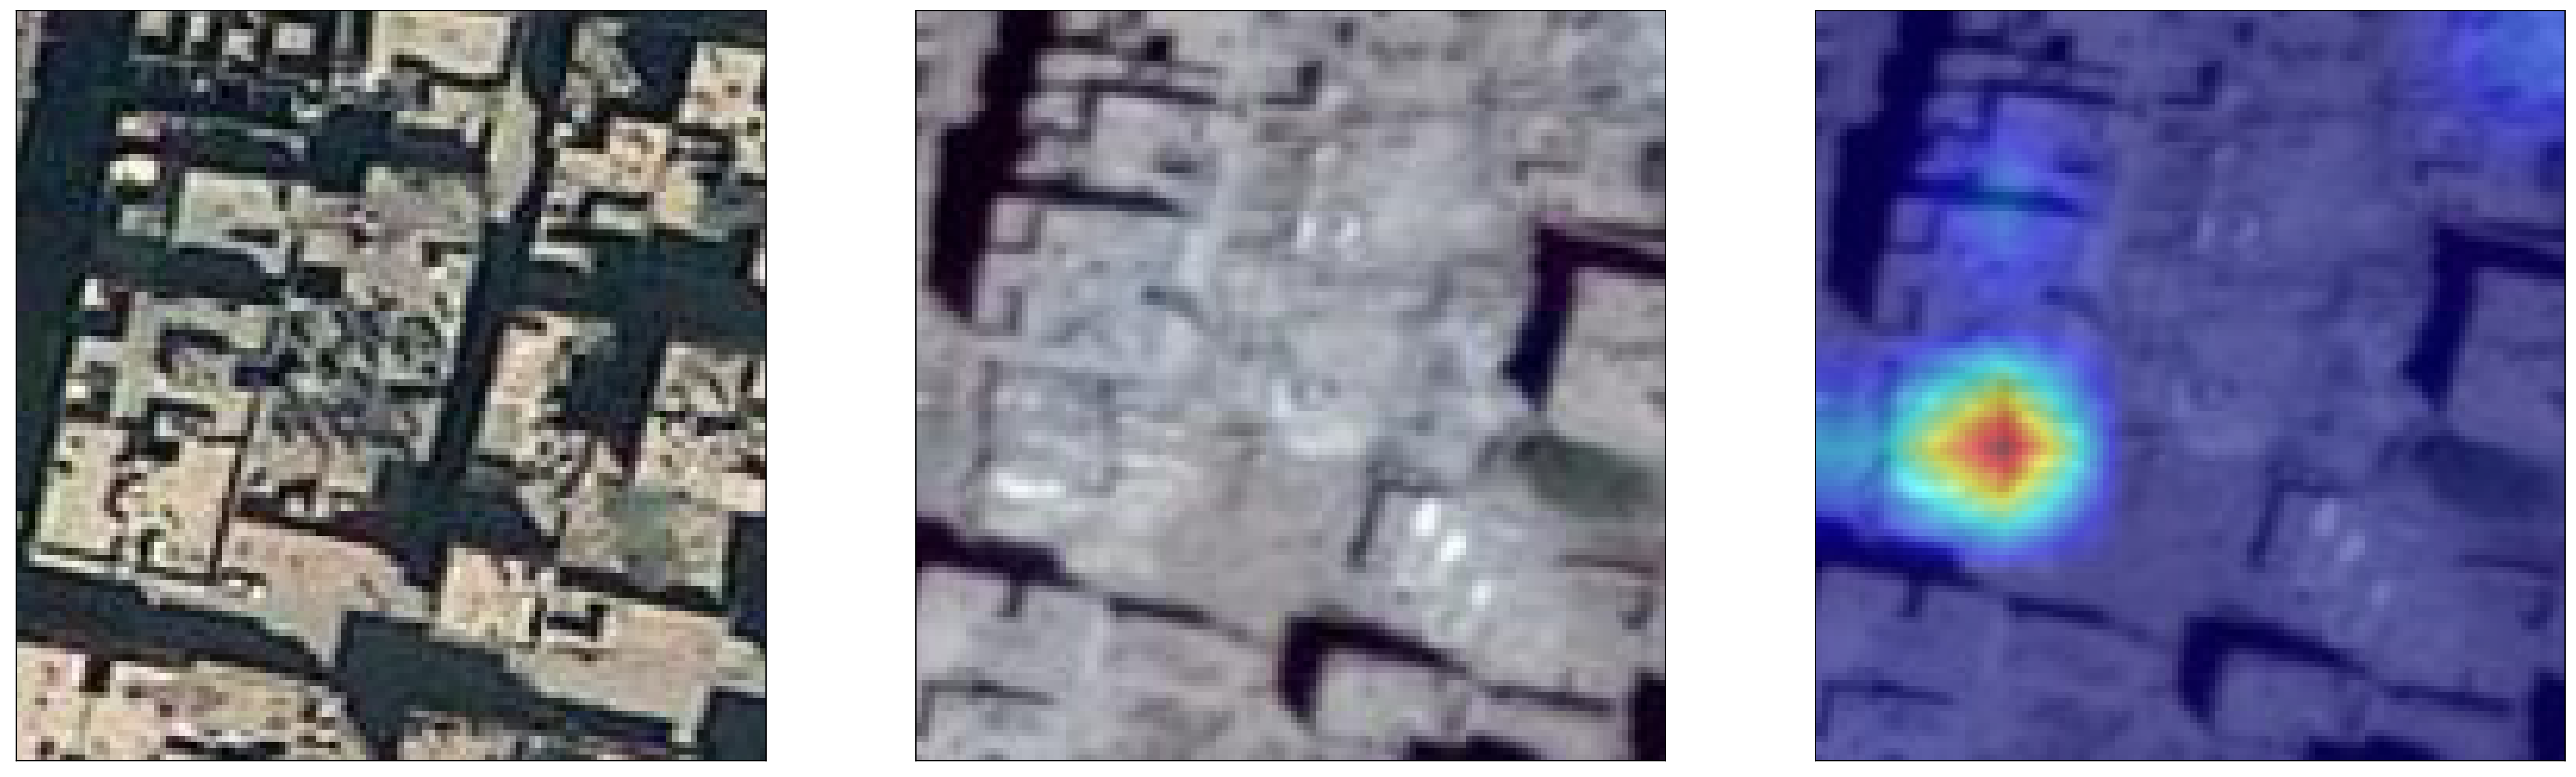

0


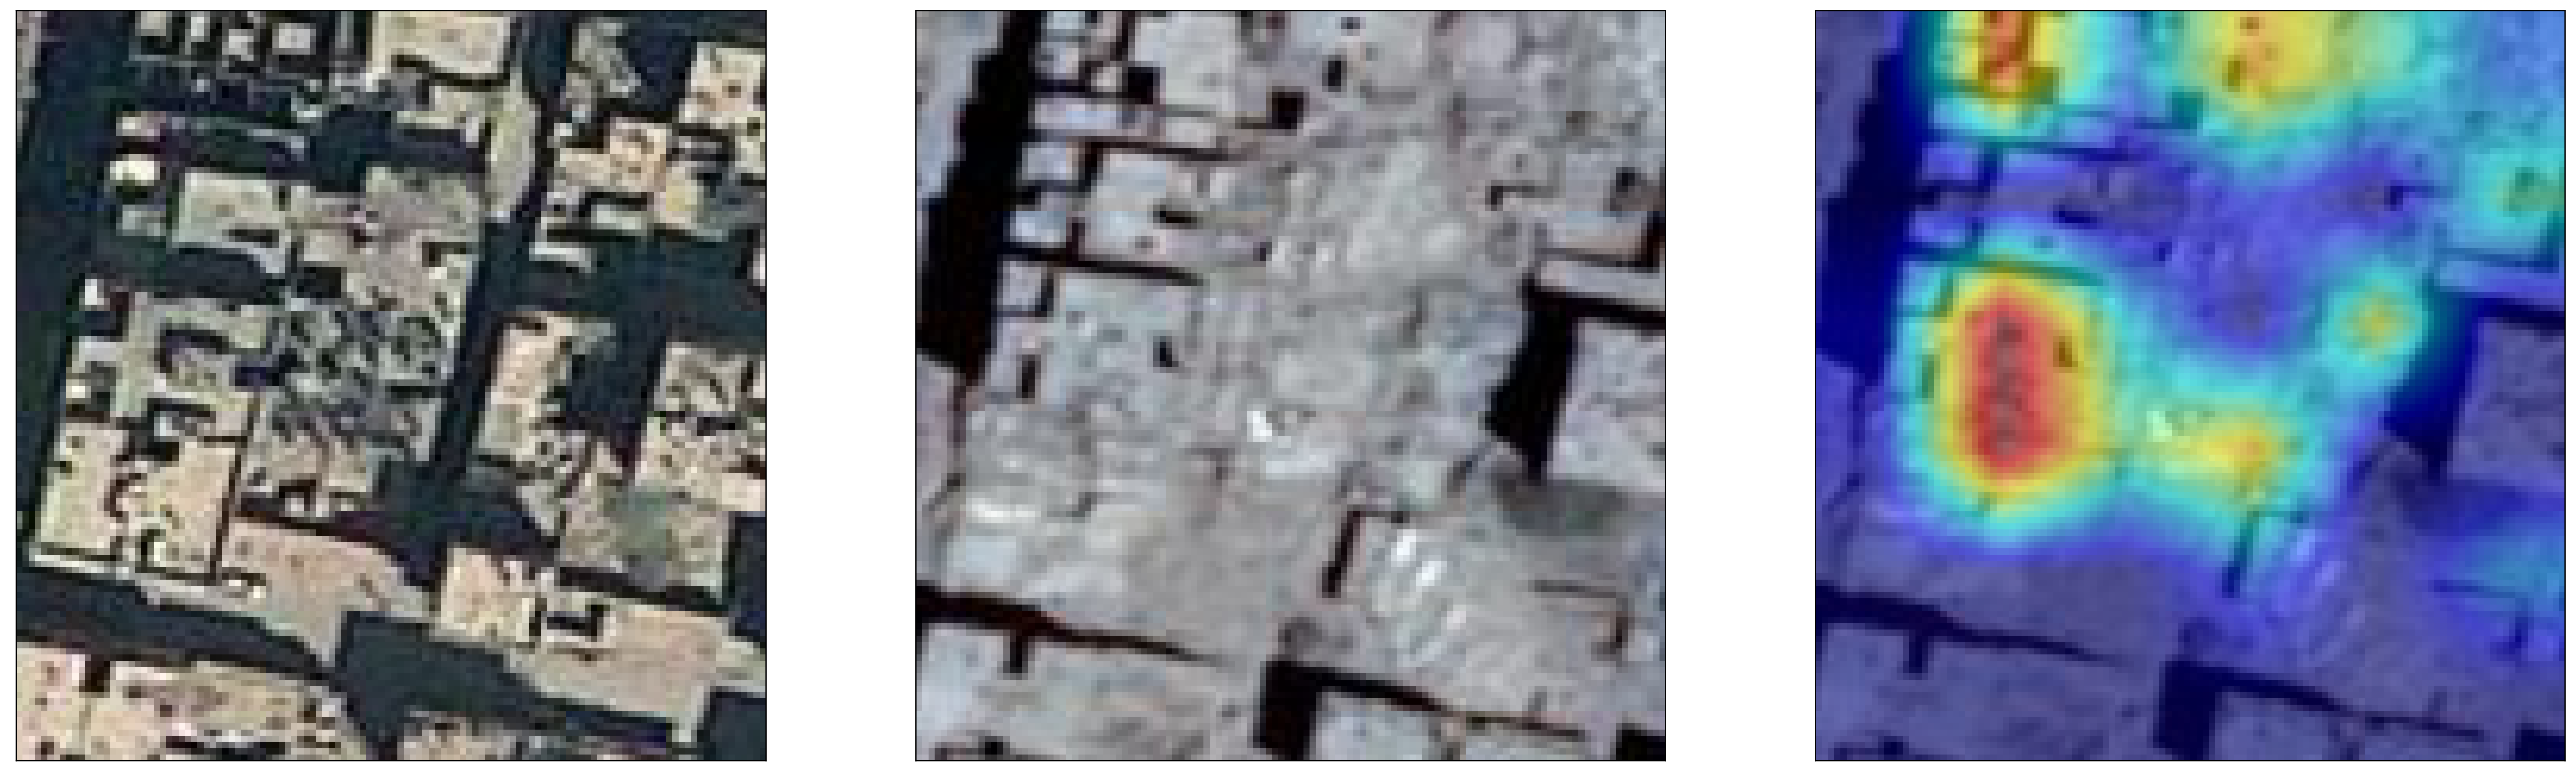

0


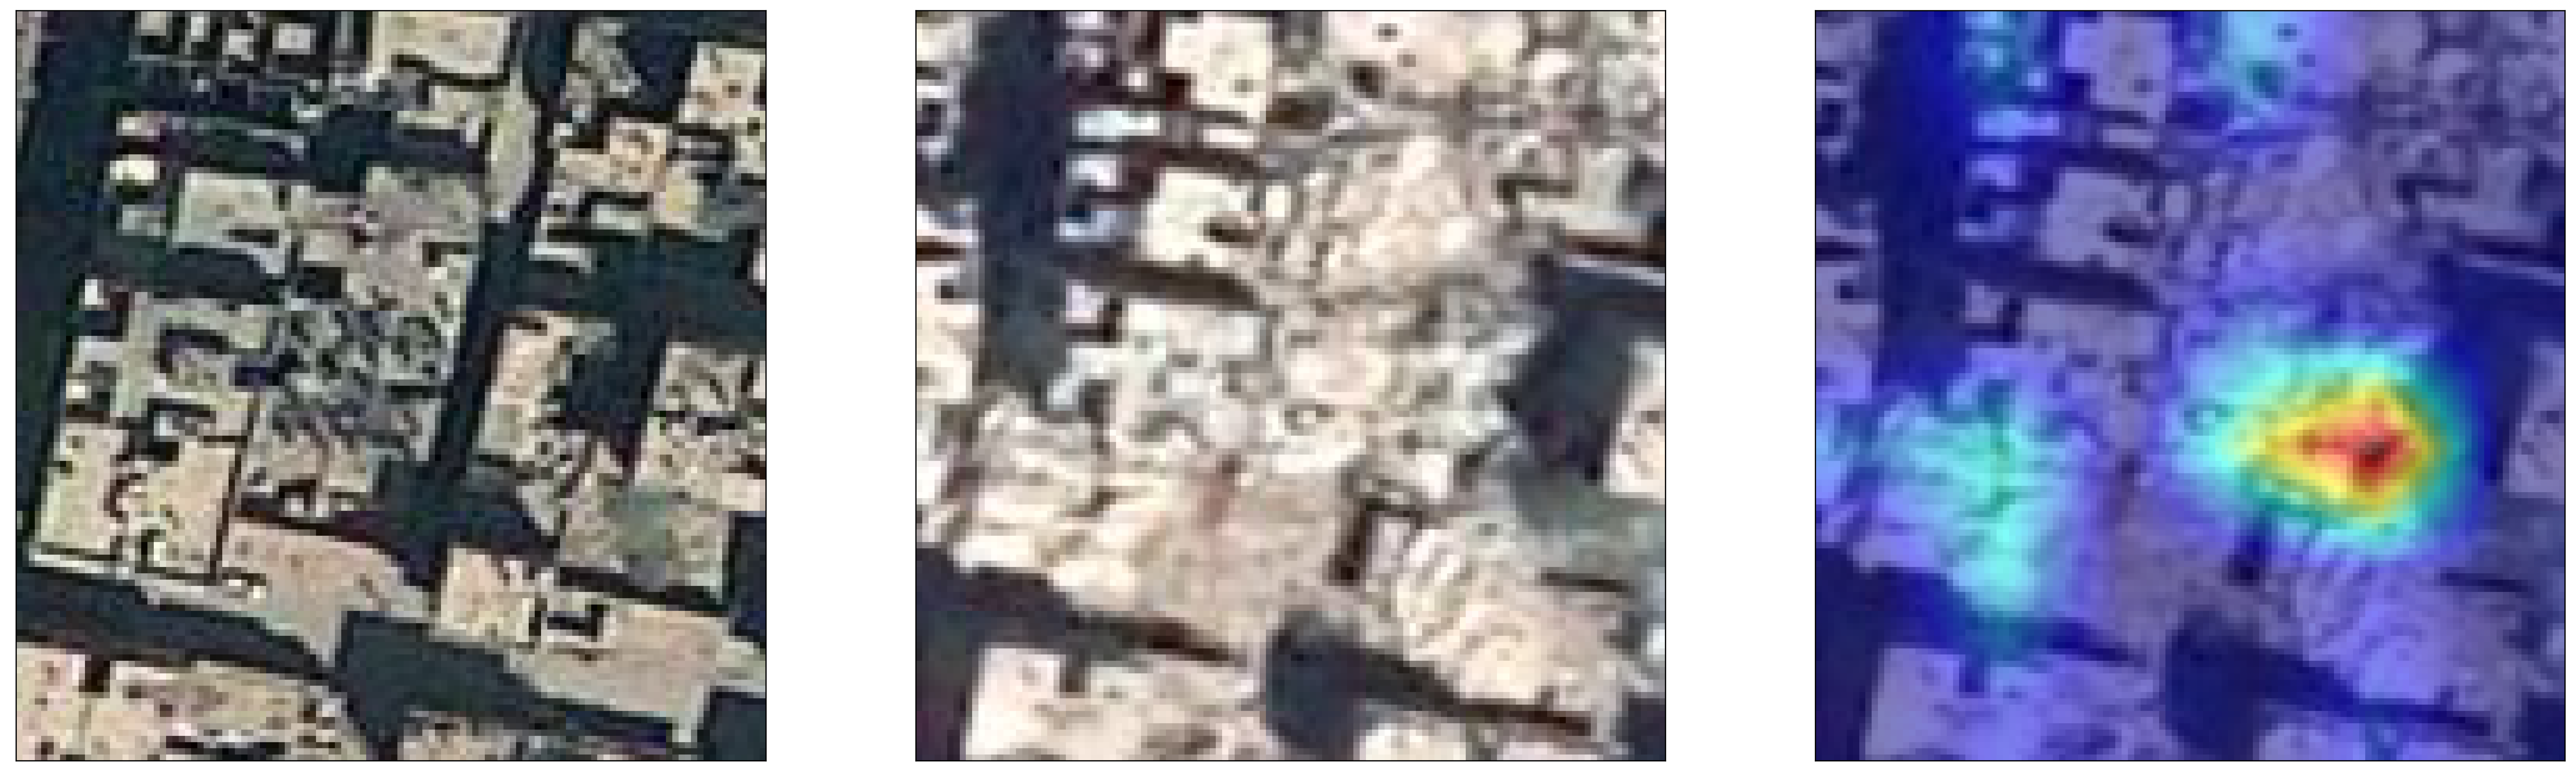

0


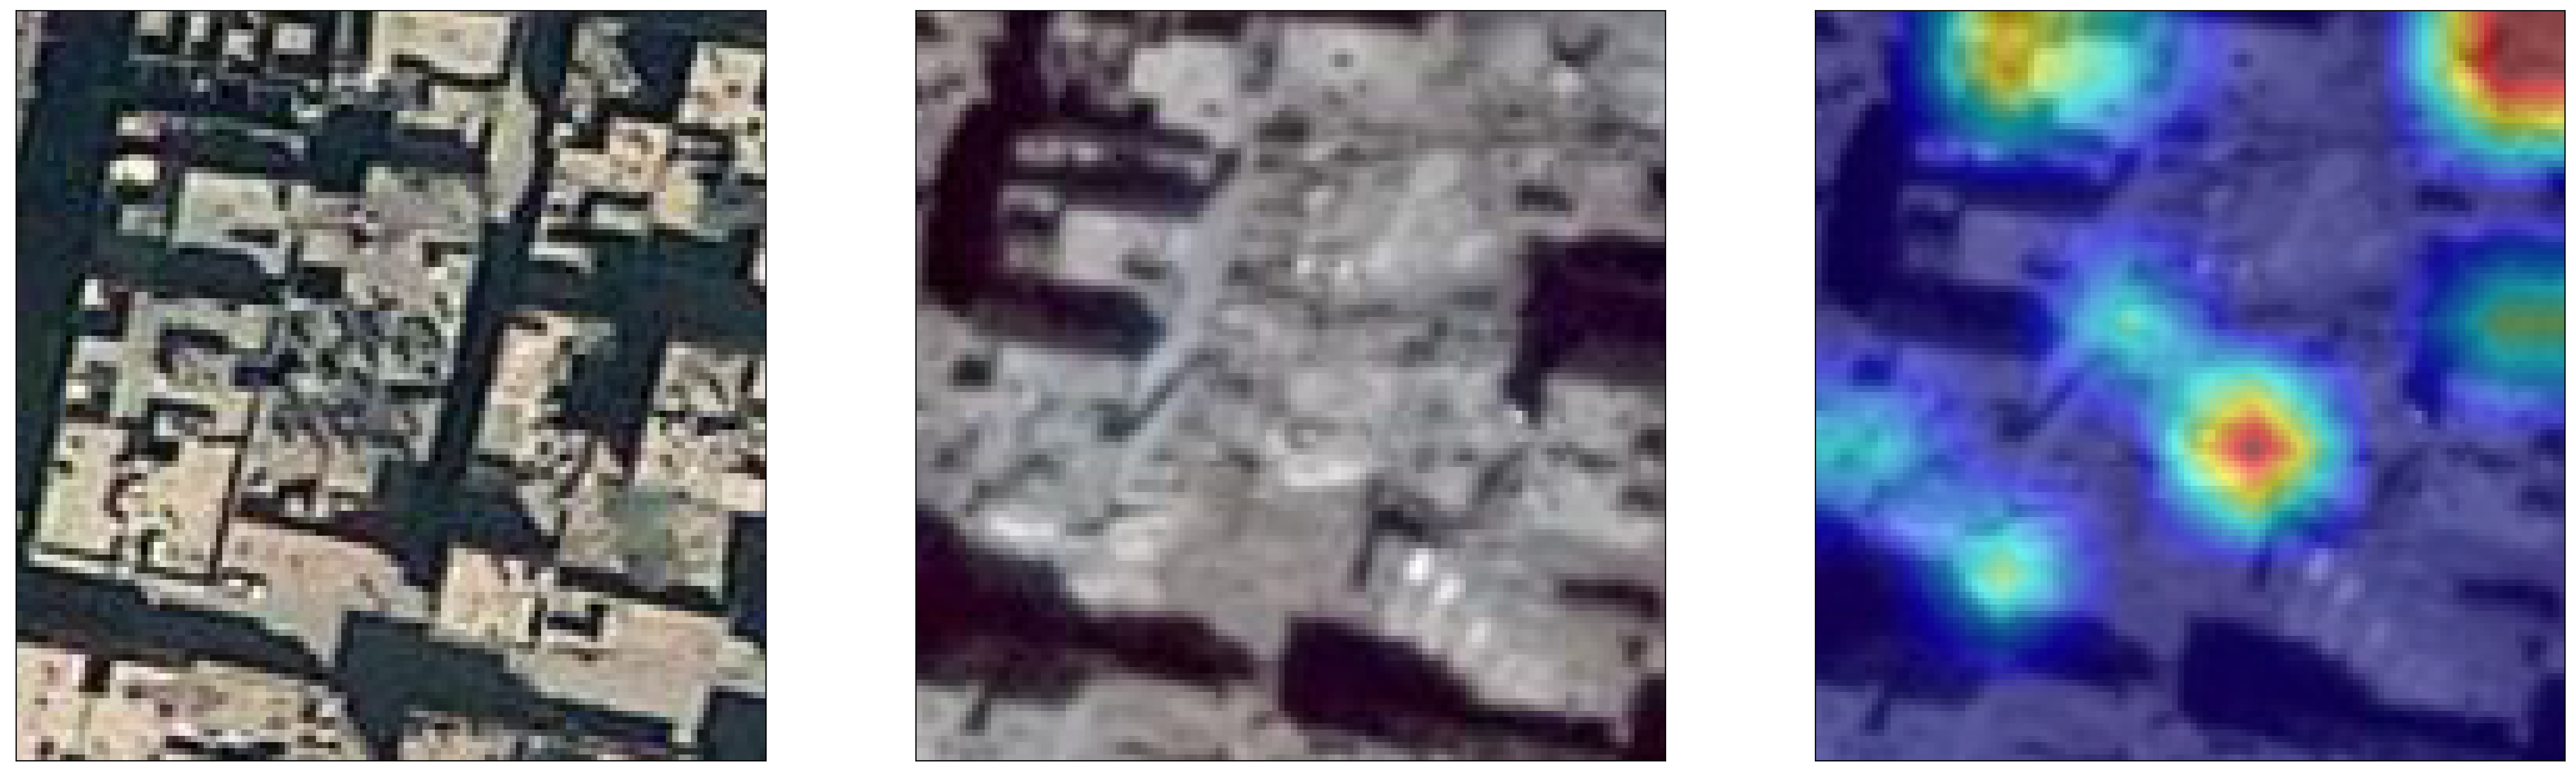

白色为未损毁，红色损毁，黄色需要标注
[1 1 1 1]
[1 1 1 1]
1


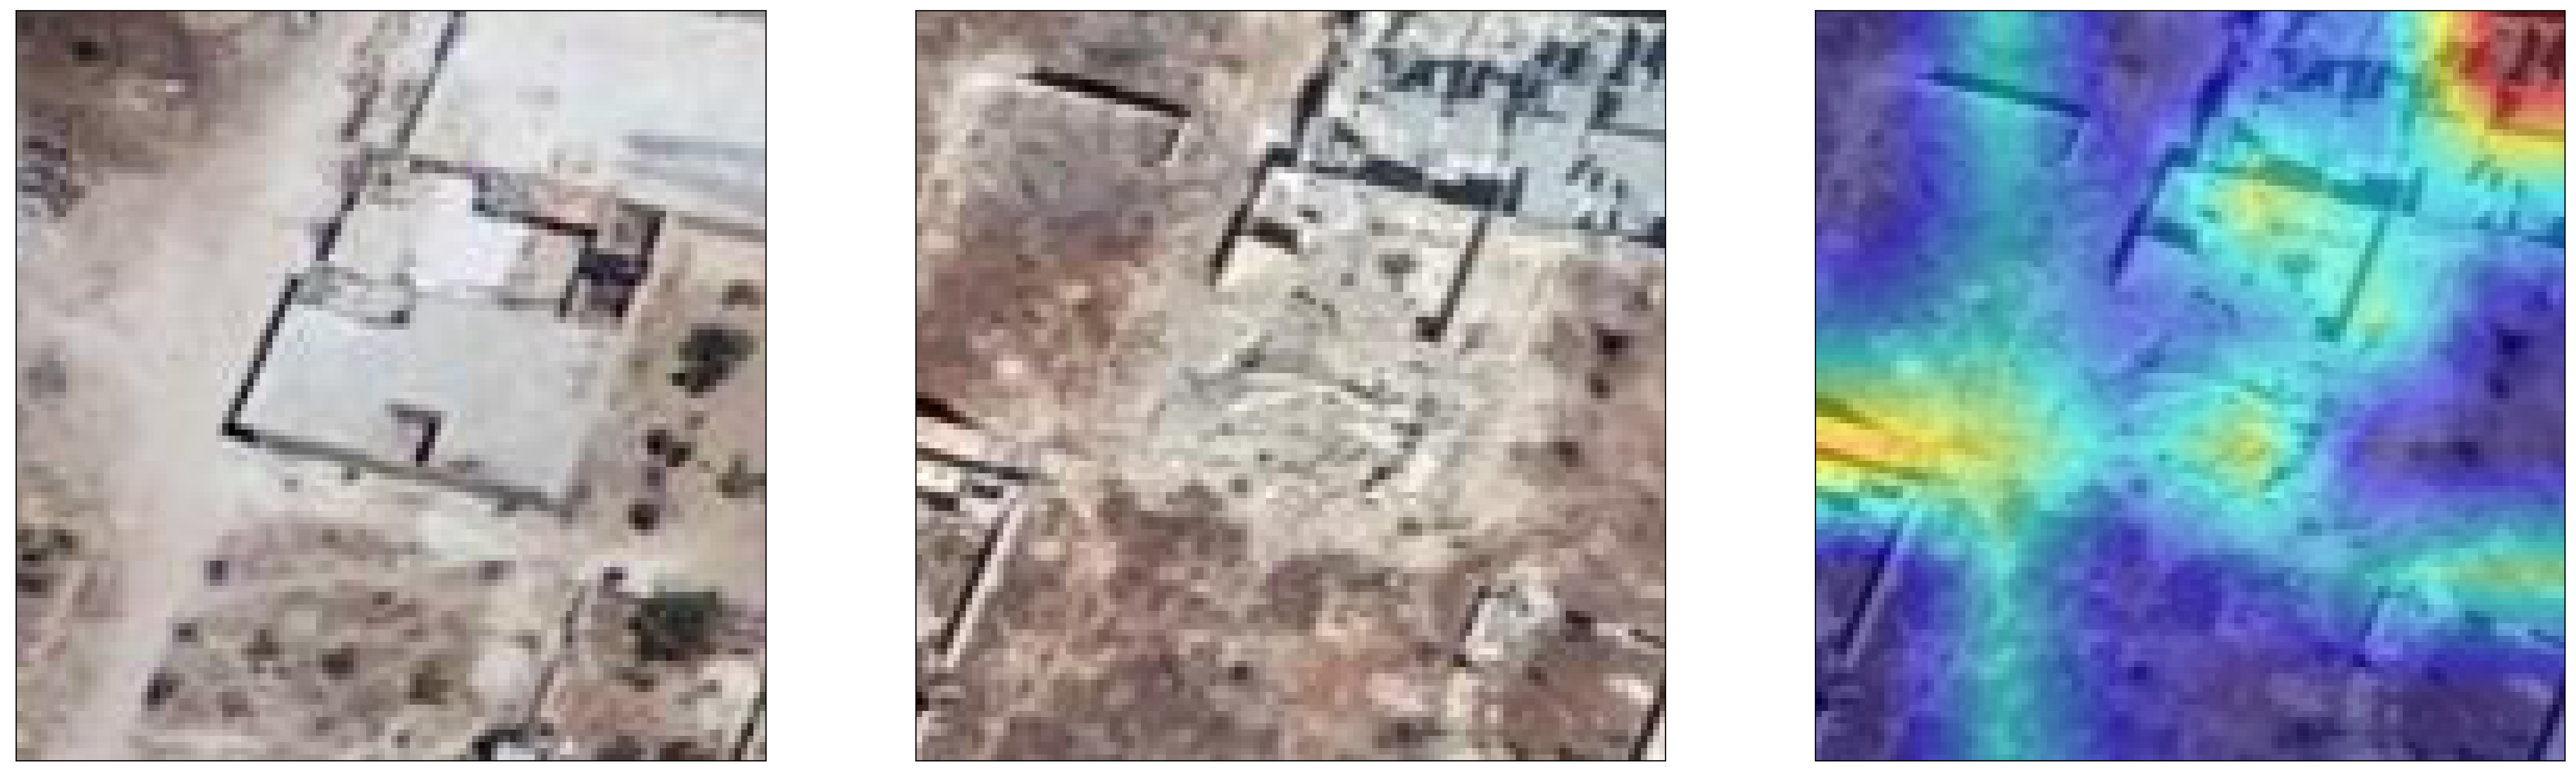

1


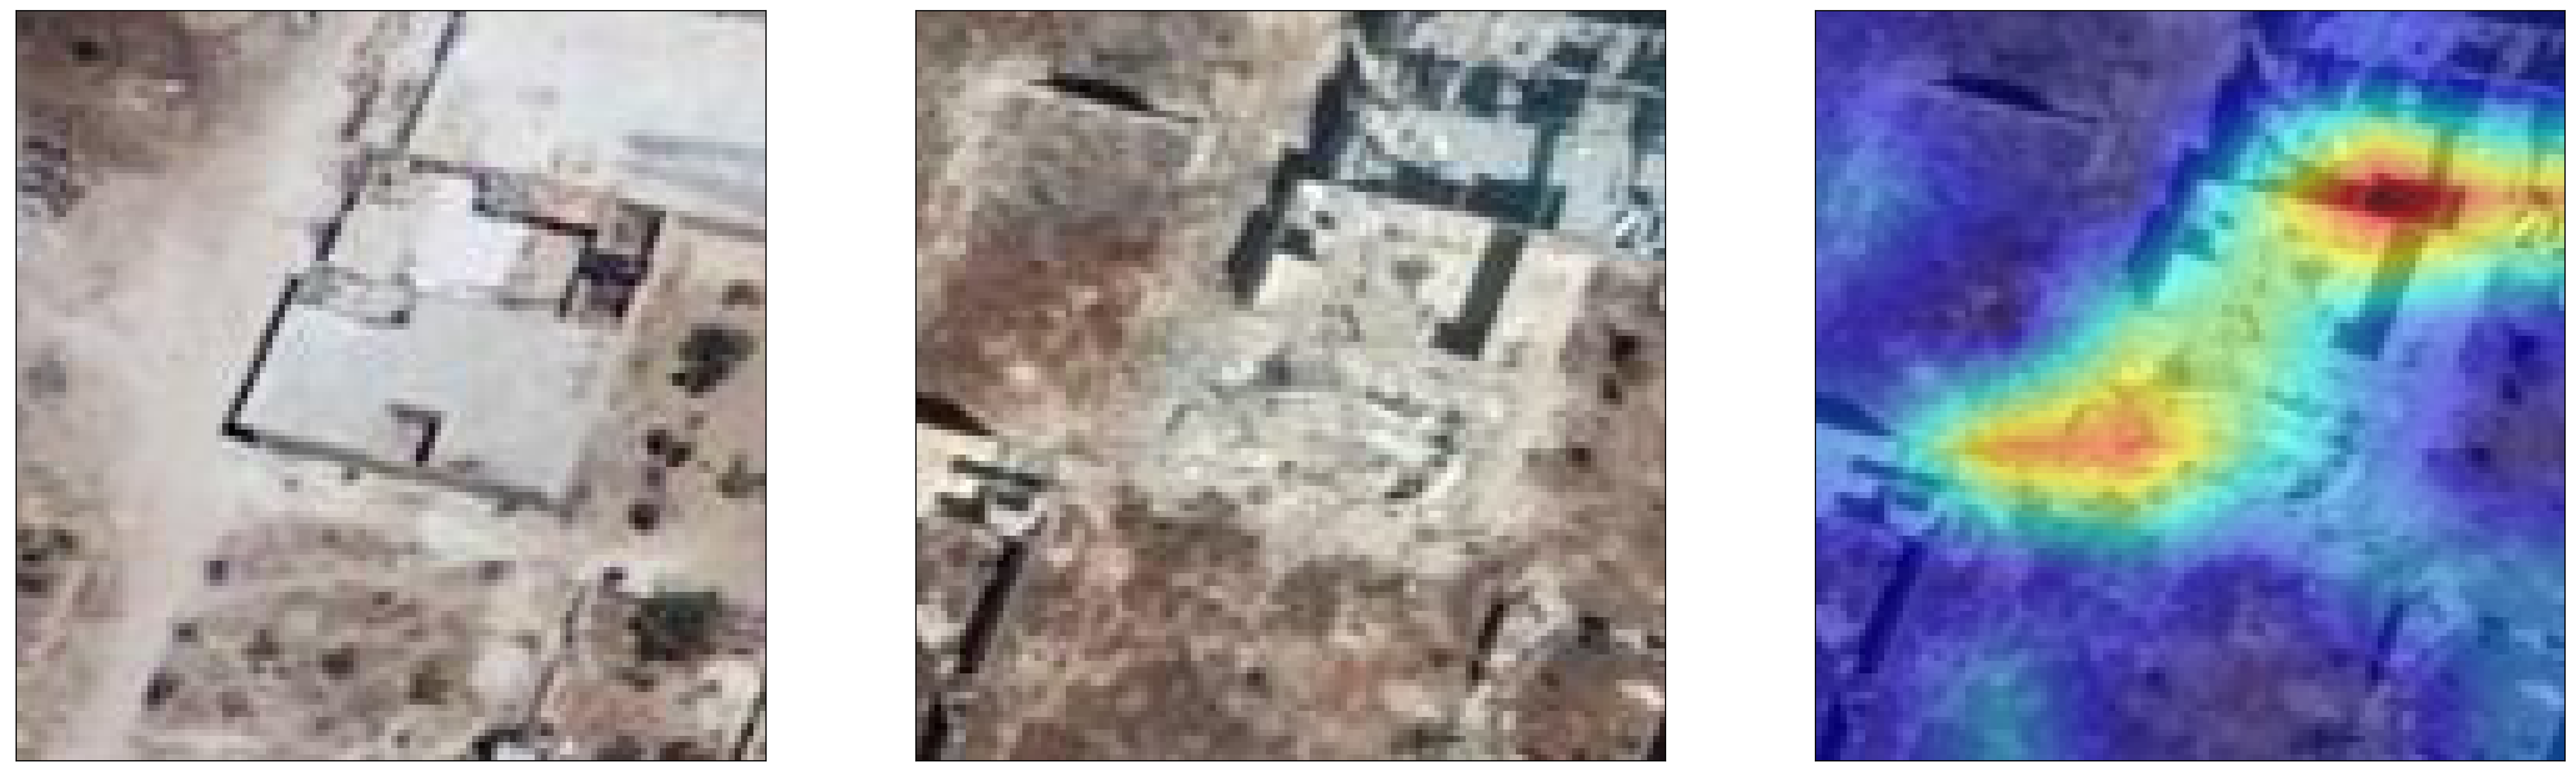

1


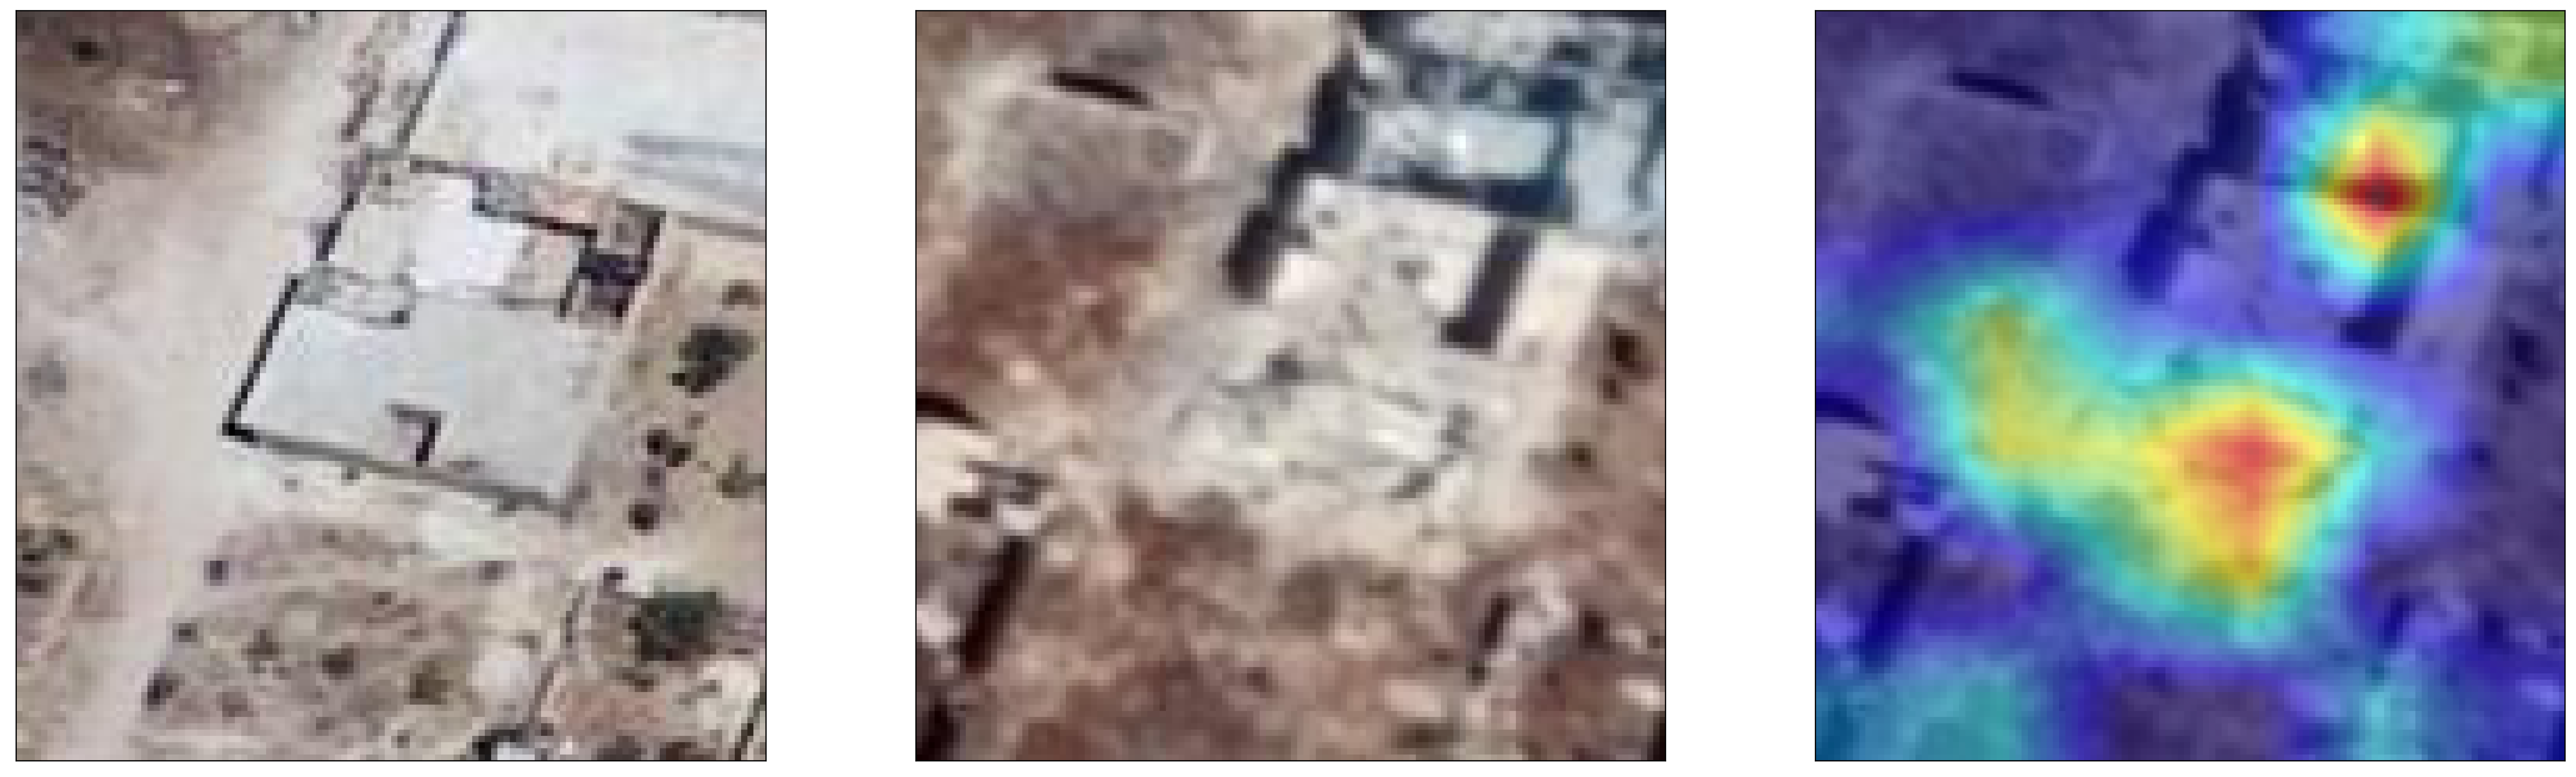

1


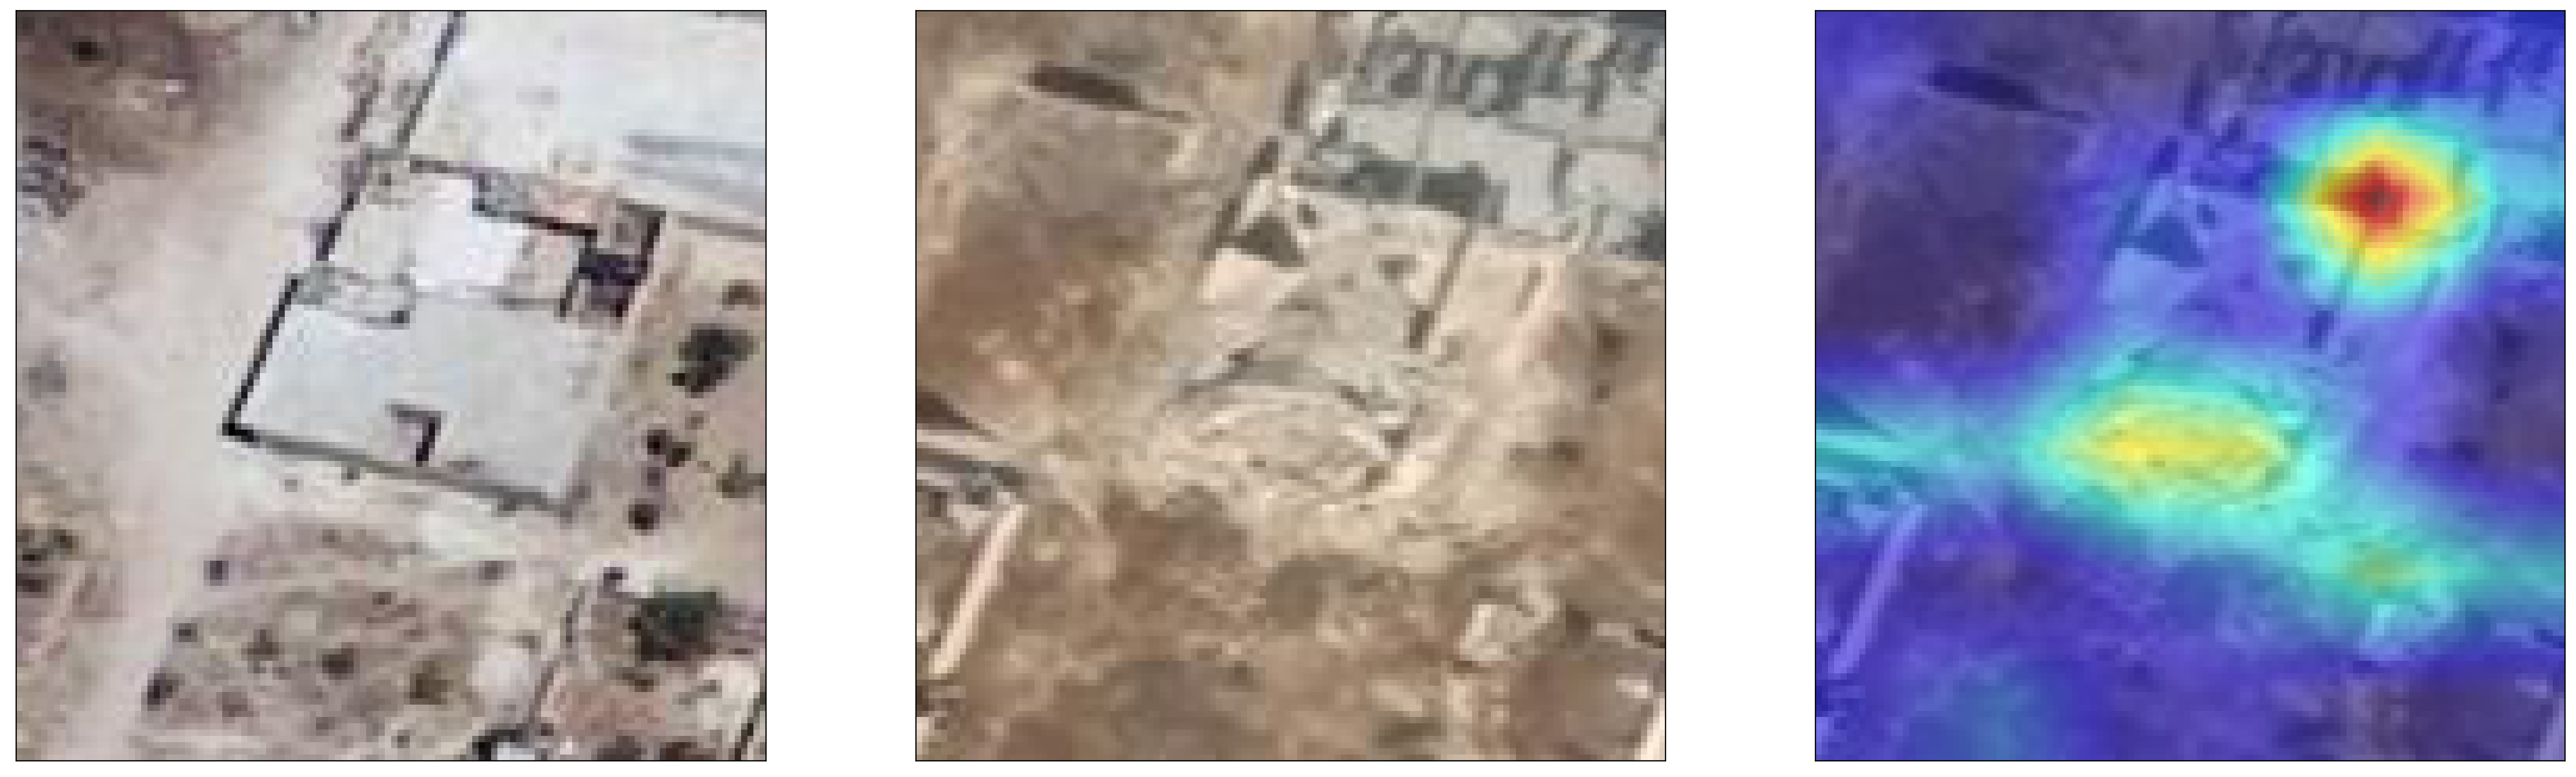

白色为未损毁，红色损毁，黄色需要标注
[1 1 1 1]
[1 1 1 1]
1


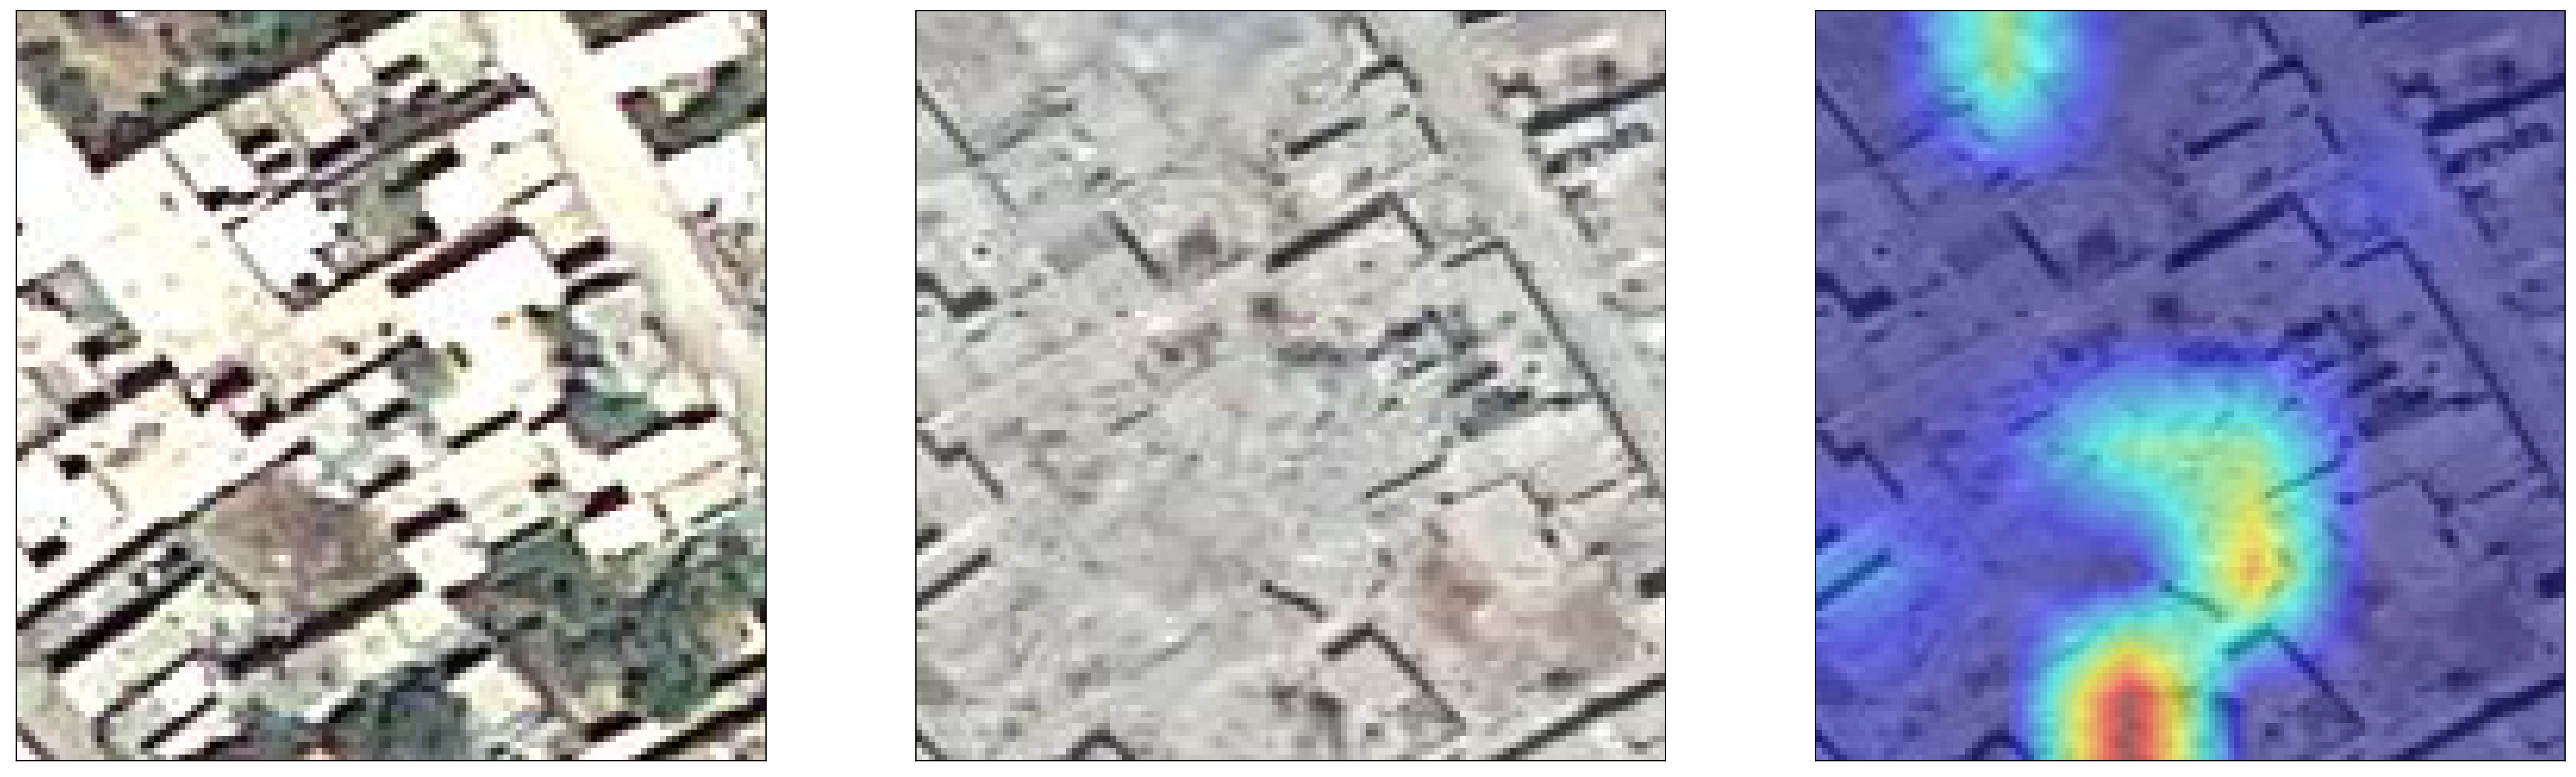

1


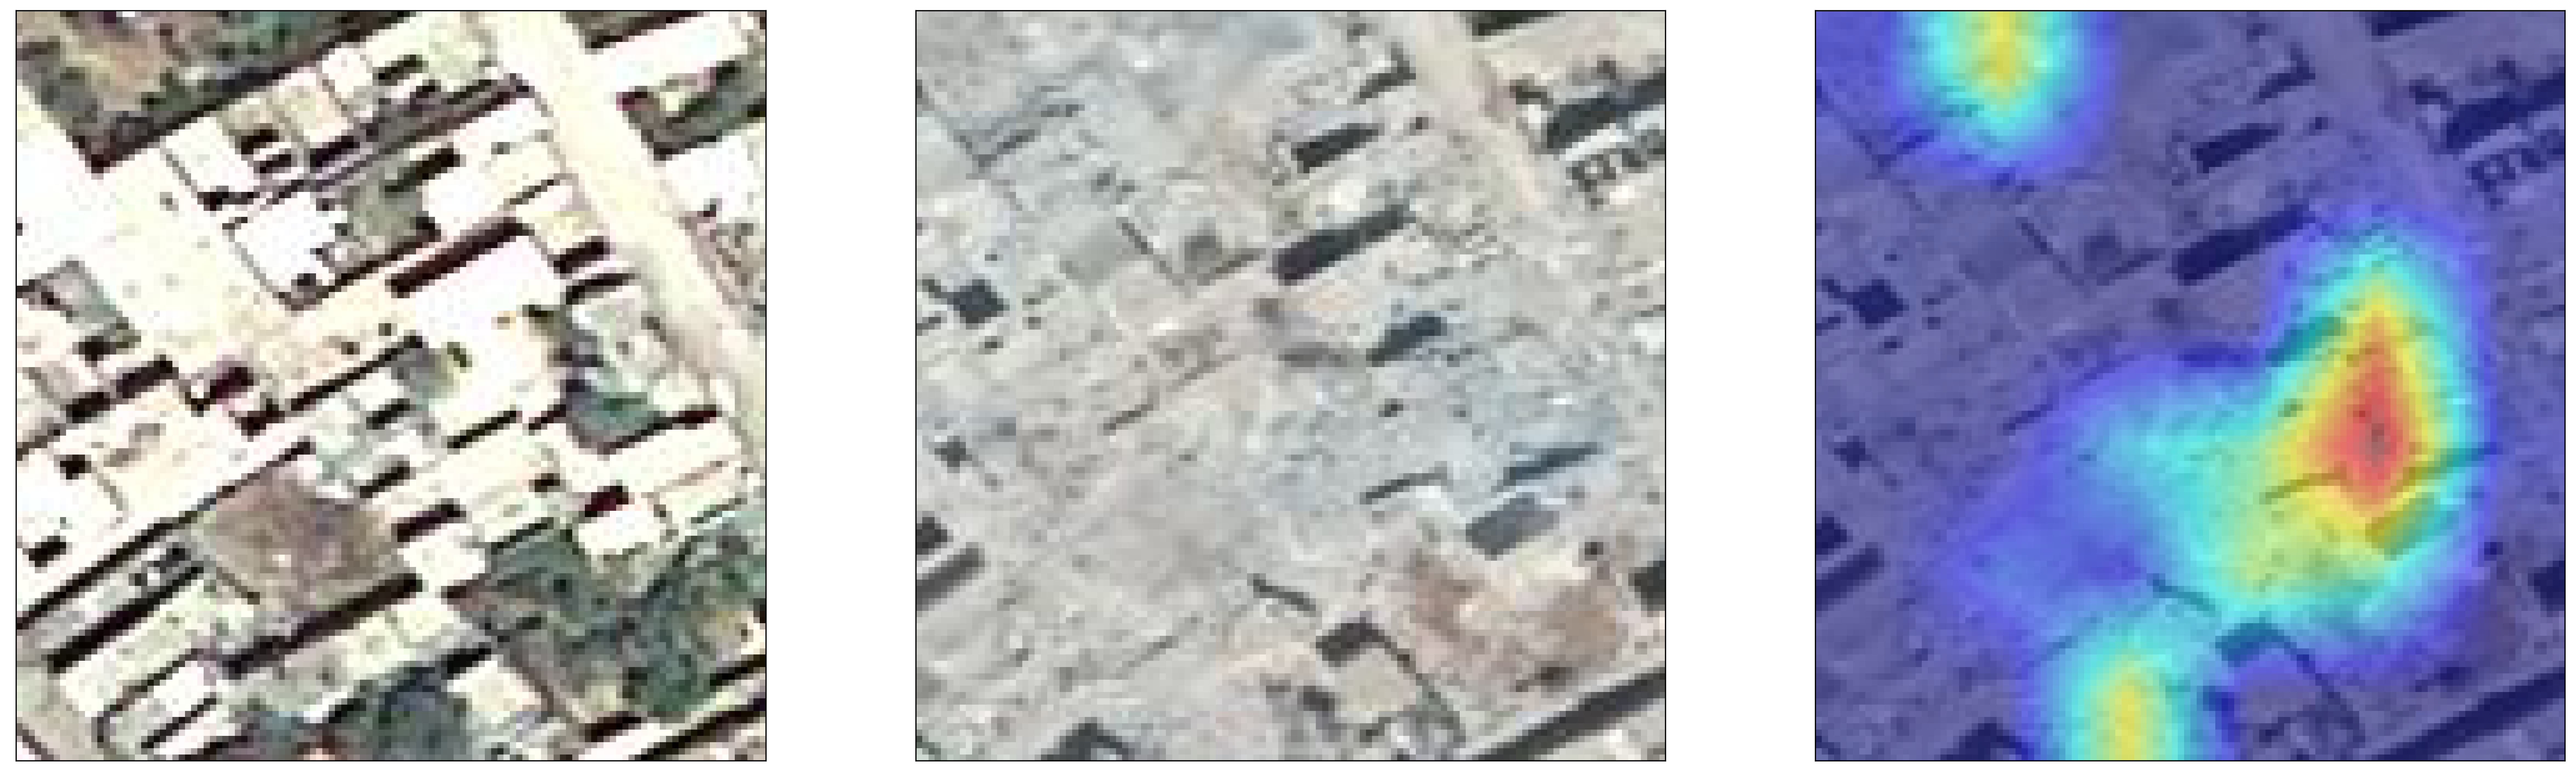

1


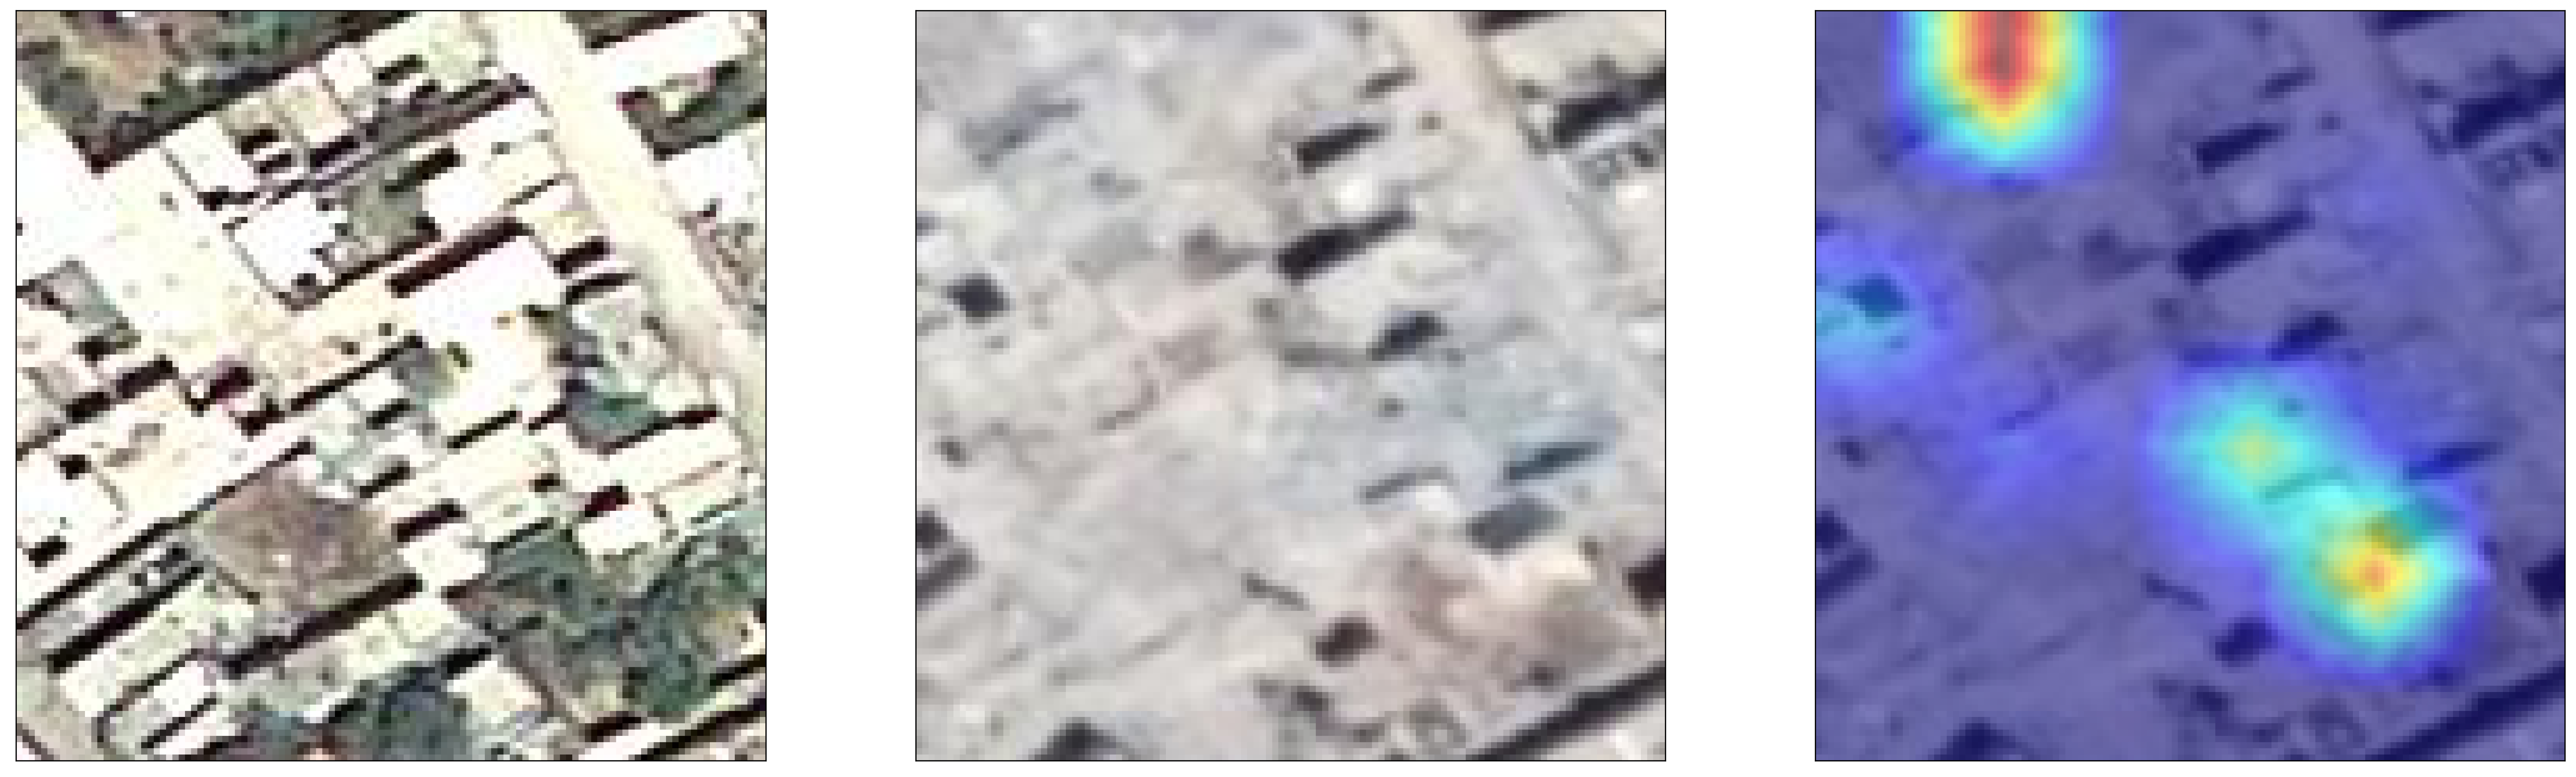

1


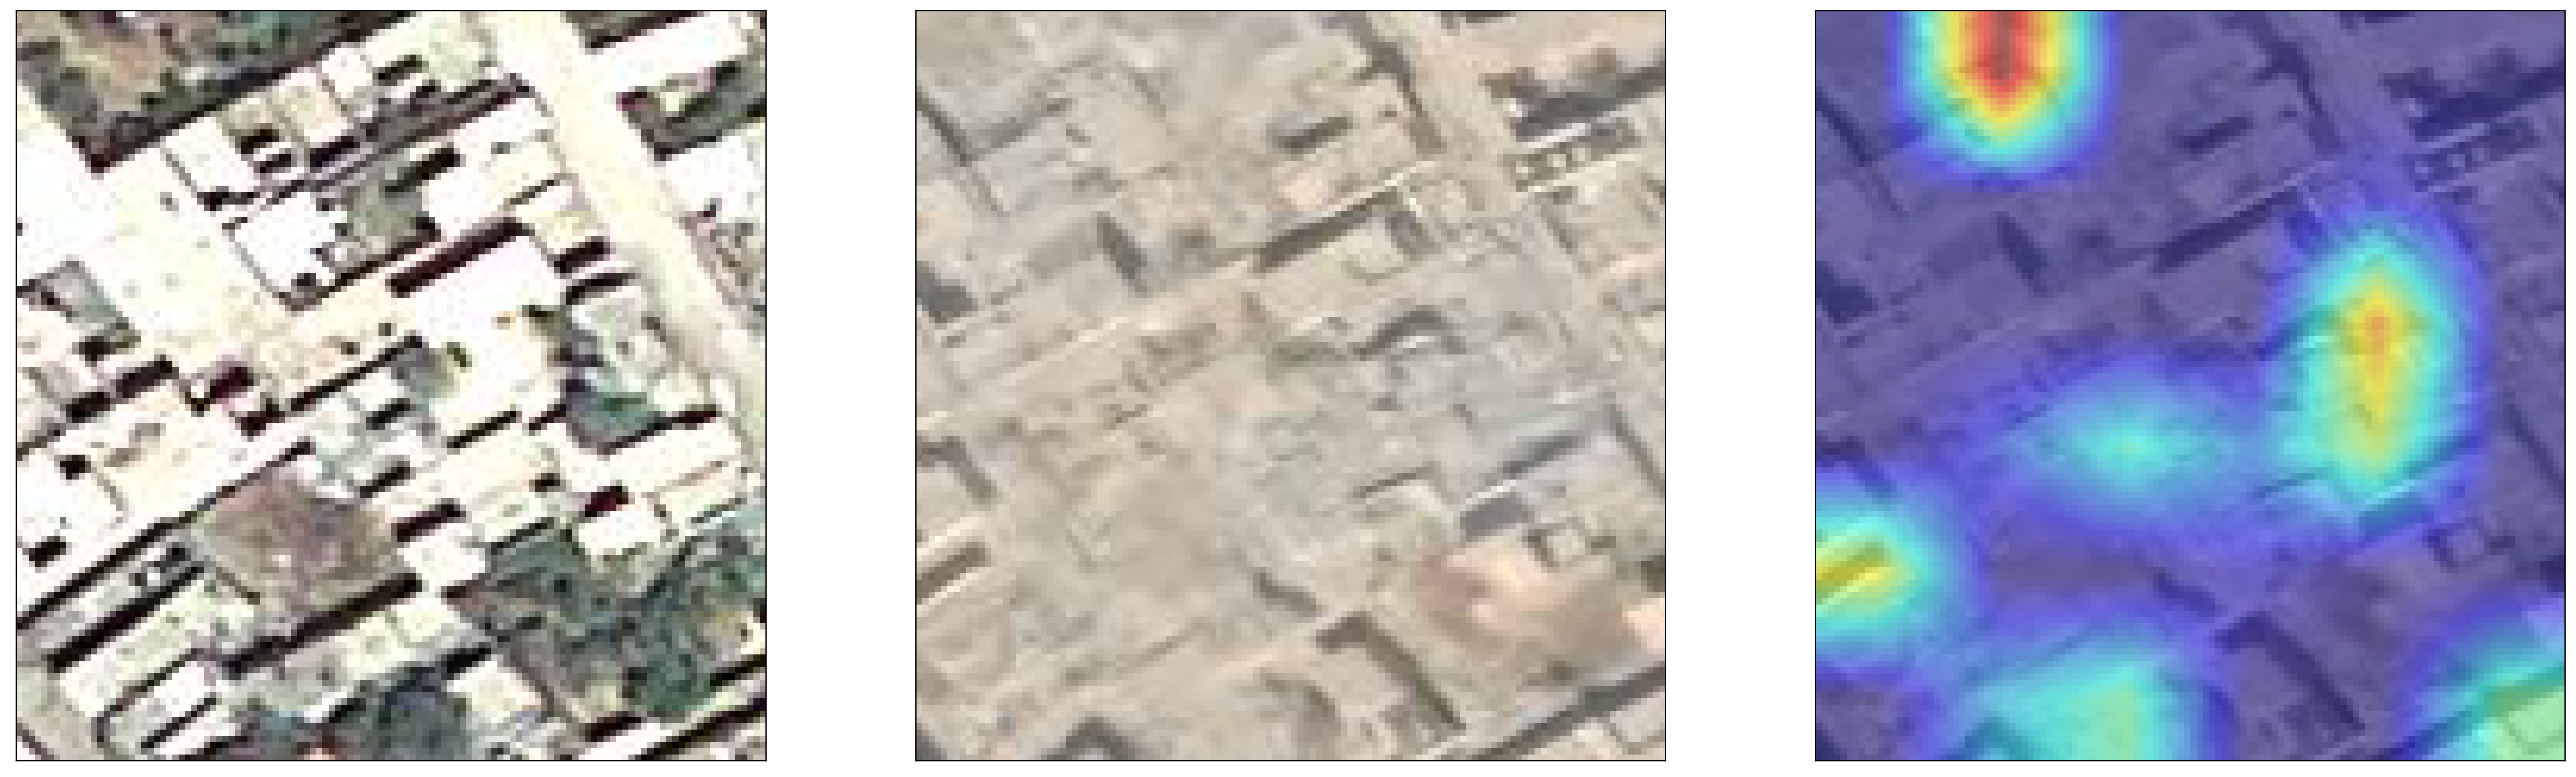

白色为未损毁，红色损毁，黄色需要标注
[1 1 1 1]
[1 1 1 1]
1


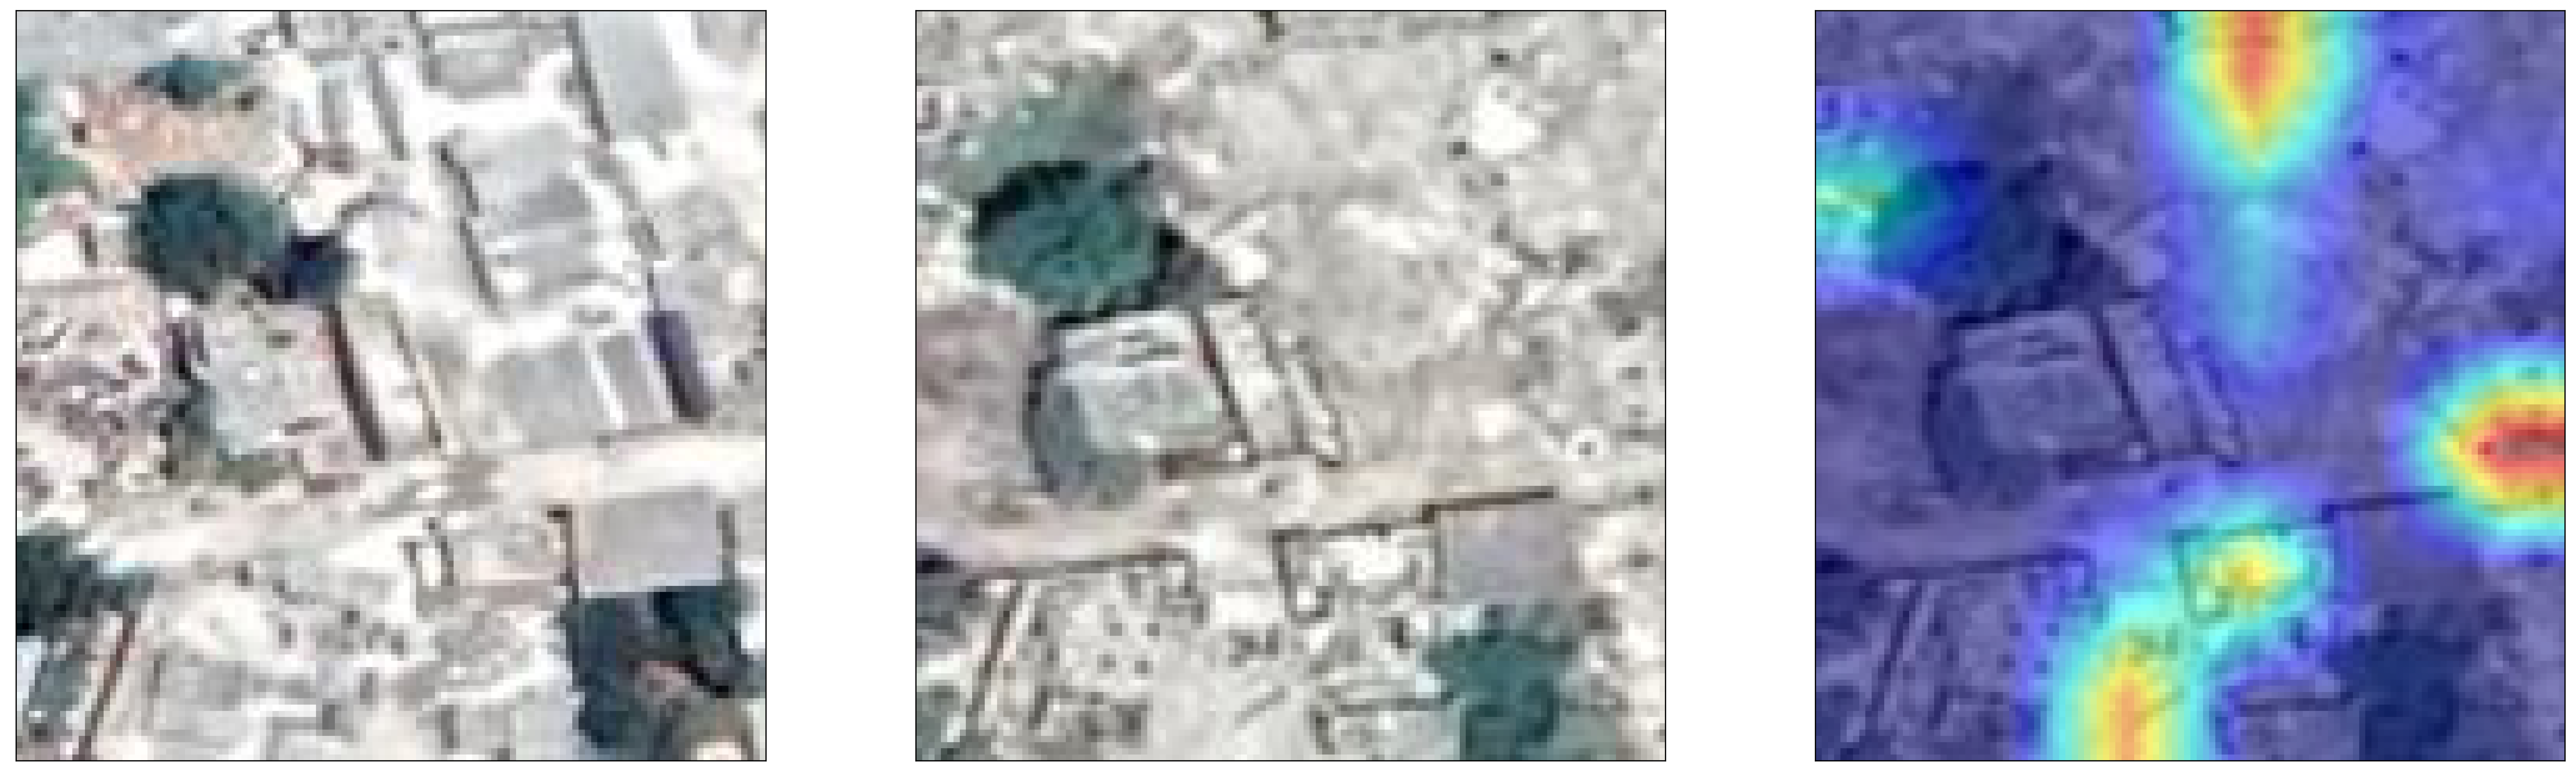

1


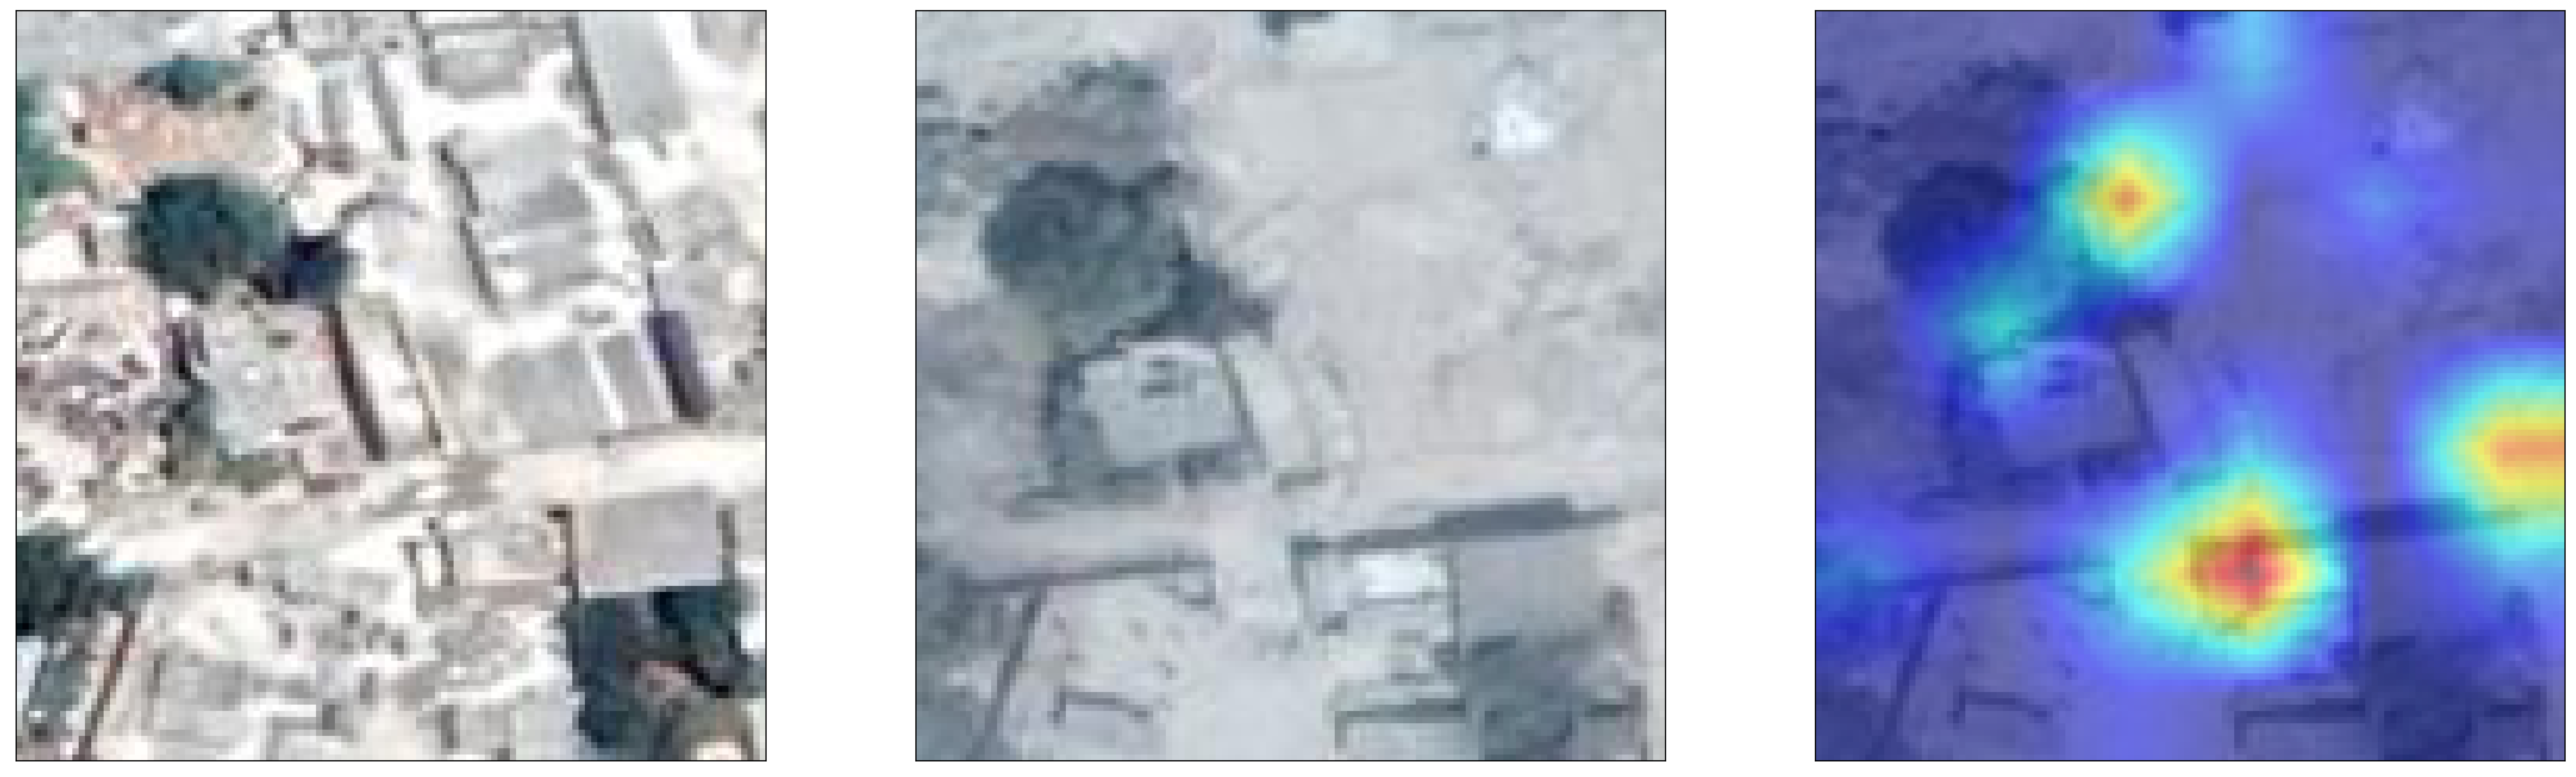

1


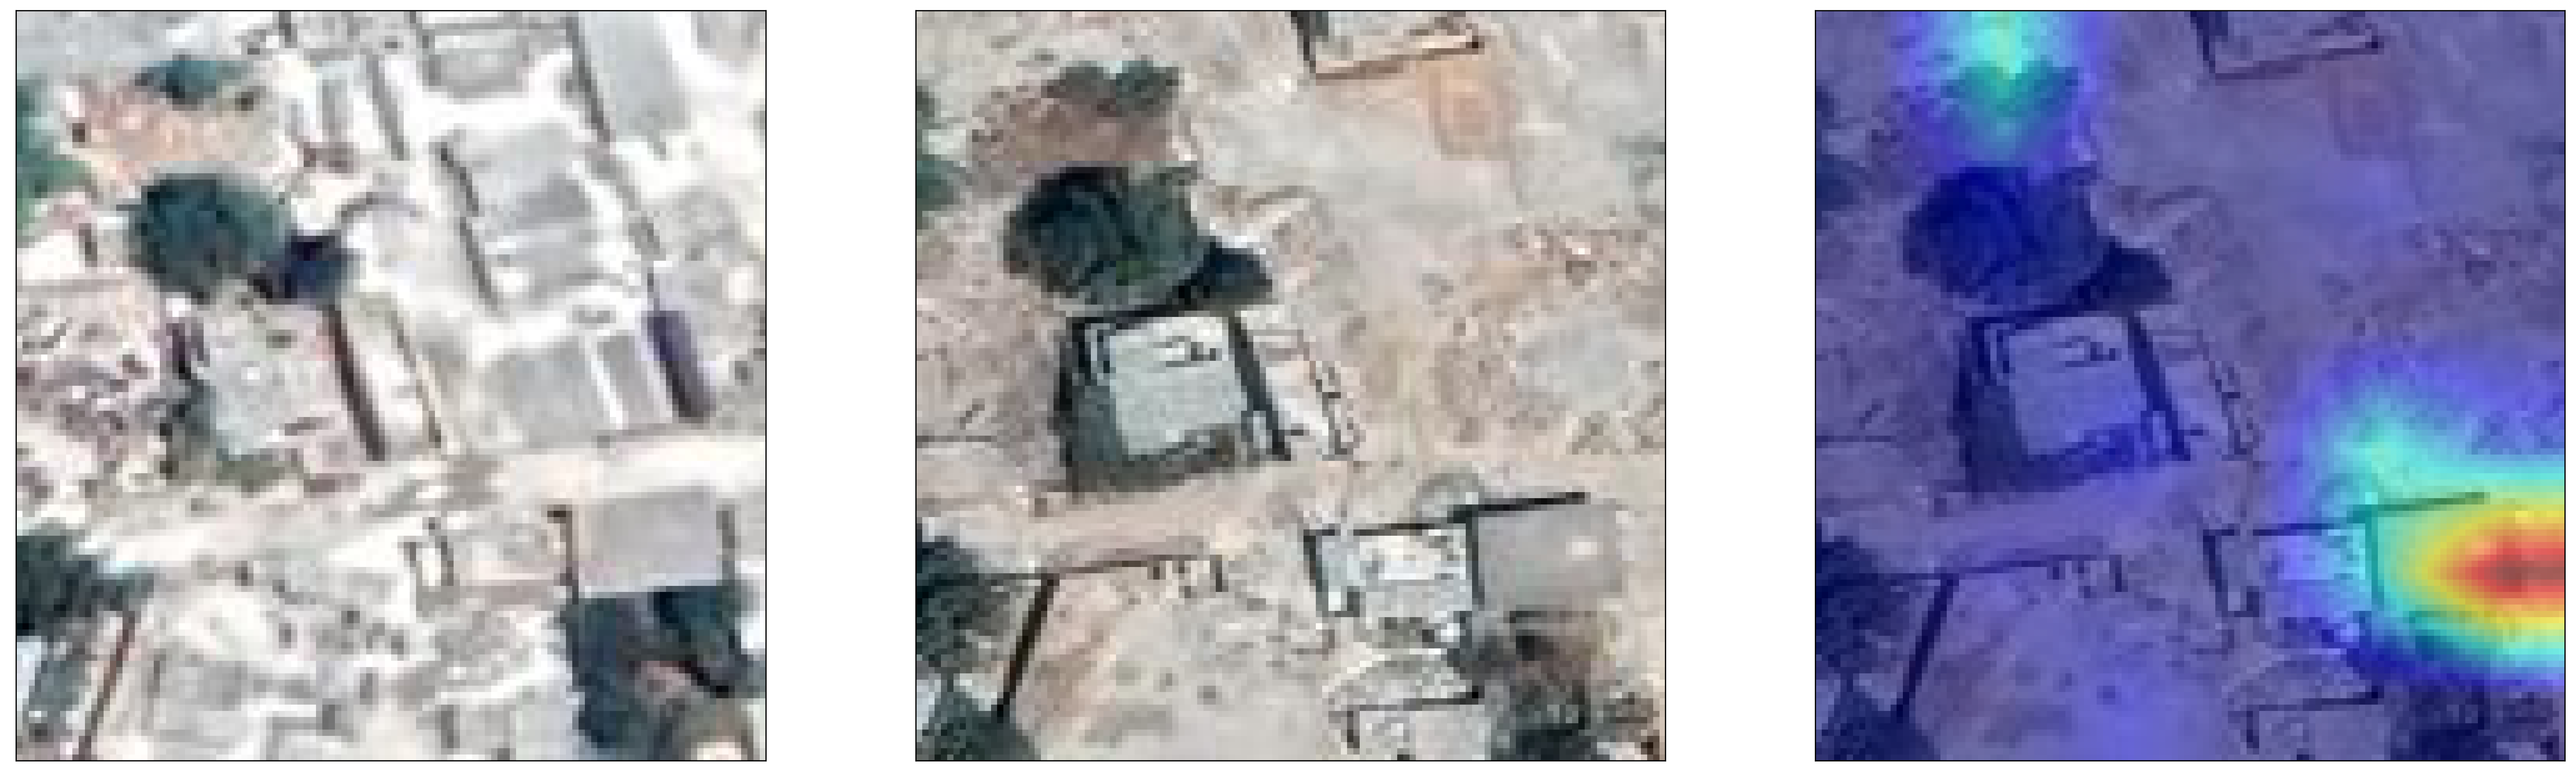

1


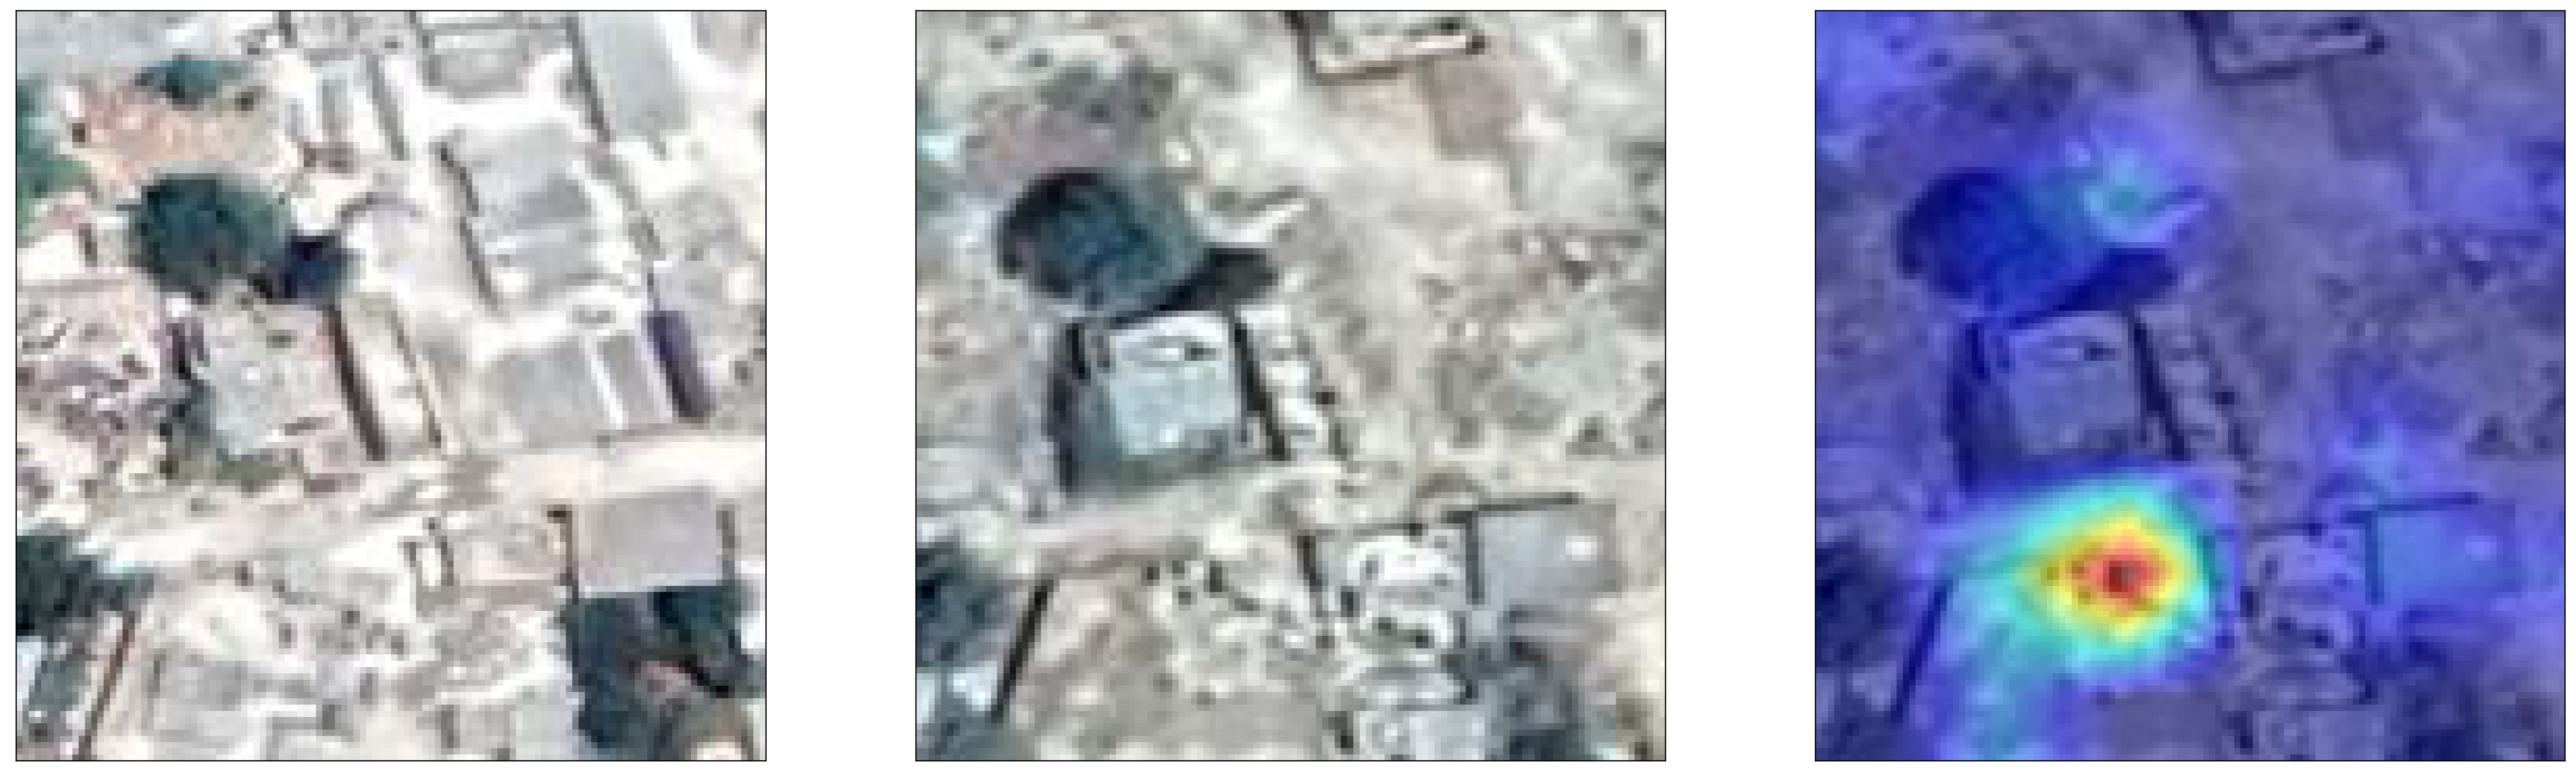

In [6]:
import matplotlib.pyplot as plt
z=0
for i,v in enumerate(loaders['val']):
    if i>4:
        raise
    print('白色为未损毁，红色损毁，黄色需要标注')
    import torch
    model=trainer2.model
    pred=model(v[0].type(torch.FloatTensor).cuda())
    pred_class=torch.argmax(pred,dim=1).cpu().numpy()
    labels=v[1].cpu().numpy()
    print(labels)
    print(pred_class)
    target_layers=[model.module.se]#PtNet
    # target_layers=[model.stack4[-1]]#resnet50
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
    target_category = 1  # tabby, tabby cat
    # target_category = 254  # pug, pug-dog
    for i in range(4):
        # if pred_class[i]==labels[i] and pred_class[i]==1:

        print(pred_class[i])
        pre_show=(np.array(v[0][i,:3])*255).astype(np.int16).transpose((1,2,0))
        post_show=(np.array(v[0][i,3:])*255).astype(np.int16).transpose((1,2,0))

        city=os.path.basename(v[2][i]).split('_')[0]
        coord=v[2][i].split('_')[-1][:6]
        l=os.path.basename(v[2][i]).split('_')[1]

        if 'enhance' in l:
            l=l[8:]

        label=pred_class[i]
            # print(label)

        # if l[0] in ['B','C','D','E','F']:       
        #     mask=np.load('/ssd/hk/Syria_samples/samples_rebuilding/label/'+f'{city}_{l[0]}_{coord}.npy')
        #     d_coords=np.array(np.where(mask>0))
        #     for j in range(d_coords.shape[1]):
        #         d_coord=d_coords[:,j]
        #         if label==1:
        #             post_show[d_coord[0]-5:d_coord[0]+5,d_coord[1],:]=0
        #             post_show[d_coord[0],d_coord[1]-5:d_coord[1]+5,:]=0
        #             post_show[d_coord[0]-5:d_coord[0]+5,d_coord[1],0]=255
        #             post_show[d_coord[0],d_coord[1]-5:d_coord[1]+5,0]=255
        #         elif label==0:
        #             post_show[d_coord[0]-5:d_coord[0]+5,d_coord[1],:]=255
        #             post_show[d_coord[0],d_coord[1]-5:d_coord[1]+5,:]=255




        grayscale_cam = cam(input_tensor=torch.unsqueeze(v[0][i].cuda(), dim=0), target_category=target_category)

        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(post_show / 255.,
                                            grayscale_cam,
                                            use_rgb=True)


        fig = plt.figure(figsize=(30,10),dpi=400)
        ax = fig.add_subplot(1,3,1)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(pre_show)
        ax = fig.add_subplot(1,3,2)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(post_show)
        ax = fig.add_subplot(1,3,3)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(visualization)
        fig.savefig(f'/home/hk/python_script/Ukraine/fig/PtNet_{z}_{pred_class[i]}.png')
        z+=1
        plt.show()
        # plt.imshow((np.array(v[0][i,:3])*255).astype(np.int16).transpose((1,2,0)))
        # plt.show()

In [10]:
grayscale_cam.shape

(1, 120, 120)

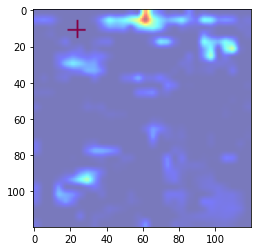

In [26]:
target_layers=[model.module.stack2[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
target_category = 1  # tabby, tabby cat
# target_category = 254  # pug, pug-dog

grayscale_cam = cam(input_tensor=torch.unsqueeze(v[0][-1], dim=0), target_category=target_category)

grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(post_show / 255.,
                                    grayscale_cam,
                                    use_rgb=True)
plt.imshow(visualization)
plt.show()

In [25]:
grayscale_cam.shape

(1, 120, 120)

In [20]:
target_layers=[model.module.se]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
target_category = 1  # tabby, tabby cat
# target_category = 254  # pug, pug-dog

grayscale_cam = cam(input_tensor=torch.unsqueeze(v[0][-1], dim=0), target_category=target_category)

# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(post_show / 255.,
#                                     grayscale_cam,
#                                     use_rgb=True)
# plt.imshow(visualization)
# plt.show()

In [22]:
grayscale_cam[0].shape

(1, 1, 120, 120)

In [39]:
model.module.trf2.layers[-1][1].fn.norm

LayerNorm((128,), eps=1e-05, elementwise_affine=True)

In [42]:
model.module.se

SELayer(
  (avg_pool): AdaptiveAvgPool2d(output_size=1)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=32, bias=False)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=512, bias=False)
    (3): Sigmoid()
  )
)

In [33]:
pip install pytorch_grad_cam

ERROR: Could not find a version that satisfies the requirement pytorch_grad_cam (from versions: none)
ERROR: No matching distribution found for pytorch_grad_cam
Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install --upgrade pip

     |████████████████████████████████| 2.1 MB 575 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.1.1
    Uninstalling pip-21.1.1:
      Successfully uninstalled pip-21.1.1
Note: you may need to restart the kernel to use updated packages.
